In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geocoder
import sklearn
from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

#### We want to build a machine learning model that looks at various intersections in Toronto and predicts the collision rates expected from cyclists at each point. Using the accident history from 1986-2010, along with information such as the intersection's Bike traffic, control type, and classification (local, major arterial etc.) we should be able to use a supervised learning approach, training our algorithm on a subset of the collisions available, and the validating on other subsets. Once we are satisfied with the performance (and at some point we'll need to define where our cut-off for prediction should be), we will compare the output by applying it to accident data scrapped from a twitterbot. 

Note that we do not include whether or not an intersection has a bike lane in our list of features. While one can download a dataset which includes all locations of cycle tracks and bike lanes by street sections, many are fairly new. With the exception of certain cycle tracks which were built after 2014, there doesn't seem to be any easy way to date various bike lane additions. As such it wouldn't make sense to label our intersections with this information, as most bike lanes and cycle tracks are fairly new, and were not around during the period of time our dataset is built from. 

#### Since we don't have access to cycle app or bikeshare data to get accurate bike counts for a variety of locations, we'll need to make due with a limited dataset of city manual and automatic bike counts. These span only a few points in Toronto, and more importantly, are focused on Downtown. 

![alt text](traffic_map.png "Traffic map")

From the bike counts above, we compared to vehicle and pedestrian counts from a sepearate data set. These are far more wide ranging, and if a relationship could be found, one could make predictions on bike traffic in all the missing points.

![alt text](traffic_fit.png "Traffic fit")

While there was unfortunately no obvious direct relationship between traffic numbers (something like a constant ratio, or a linearly increasing one), we do get an acceptable power fit when comparing the bike-to-pedestrian traffic ratio, once we filter out a few areas. The University of Toronto campus has a much higher B/P ratio than any other avaialble bike count locations. This isn't suprising, as a student there I can confirm it's the most popular place to see cyclists in the city. The other area is the waterfront right by financial and entertainment districts. These points had a far lower traffic ratio than given by this fit. So we'll treat them as seperate special cases, mapping the available bike counts directly to any nearby collisions, as long as they fit within a 'box' that we'll use to define those areas.

##### Note, done in openoffice spreadsheet. Should transfer over into Python for a prettier graph. Will perhaps change the fit equation a bit 

Next we needed to clean and filter our dataset. Cleaning mostly invovled searching for NaNs or mixed up entries, as it prevents us from easily manipulating our dataframe. Once we have things roughly cleaned up, we want to filter our collisions. The bike count to pedestrian count relationship we had was based on points that were overwhelminghly found in central Toronto; downtown and the surrounding neighborhoods. So we need some way to do this

In [2]:
col_df = pd.DataFrame.from_csv('collisions_clean.csv', index_col='ID')
col_df=col_df.sort_index()
col_df.head()

,INJURY,SAFETY EQUIP.,ROAD CLASS,CYCLIST CRASH TYPE,AGE OF CYCLIST,STNAME1,STET 1 TYPE,STNAME 2,STET 2 TYPE,LONG,...,ACC TIME,ACC TIME2,TRAFFIC CONTROL,ROAD SURFACE2,DATE,DATE2,DRIVER ACTION,DRIVER CONDITION,YEAR,INTERSECTION
ID,,,,,,,,,,,,,,,,,,,,,
1,Minimal,Unrecorded,Minor Arterial,Unrecorded,34.0,BIRCHMOUNT,RD,HIGHVIEW,AV,-79.26539,...,1000.0,10:00:00,stop sign,wet,1986/01/12,1986/01/12,Failed to yield right-of-way,Normal,1986,"Birchmount Rd & Highview Ave, Toronto, Ontario..."
2,Minimal,Unrecorded,Major Arterial,Unrecorded,54.0,LAKE SHORE,BLVD,THIRTY-FIFTH,ST,-79.53500,...,1000.0,10:00:00,no control,wet,1986/01/19,1986/01/19,Improper turn,Normal,1986,"Lake Shore Blvd W & 35th St, Toronto, Ontario,..."
3,Minor,Unrecorded,Major Arterial,Unrecorded,19.0,LAWRENCE,AV,FORTUNE,GATE,-79.21800,...,1500.0,15:00:00,no control,dry,1986/01/23,1986/01/23,Failed to yield right-of-way,Normal,1986,"Lawrence Ave E & Fortune Gate, Toronto, Ontari..."
4,Minimal,Unrecorded,Local,Unrecorded,34.0,EUCLID,AV,ULSTER,ST,-79.41330,...,800.0,08:00:00,no control,loose snow,1986/01/14,1986/01/14,Lost control,Normal,1986,"Euclid Ave & Harbord St, Toronto, Ontario, M6G"
5,Minimal,Unrecorded,Major Arterial,Unrecorded,34.0,AVENUE,AV,DRAYTON,AV,-79.32041,...,1700.0,17:00:00,traffic signal,dry,1986/01/30,1986/01/30,Other,Normal,1986,"Danforth Ave & Drayton Ave, Toronto, Ontario, M4C"


The above collisions were all geocoded based on the crosstreets listed, rather than the GPS coordinates, since there were many coordinates that just were defaulted to the center of Toronto. Nonetheless, there were still a few "impossible" intersections, that were then geocded in a second pass using their coordinates. 

We also use a list of ALL the intersections in the city, and geocode those, using the GPS coordinates. These also required a second pass using a different geocoder on about 10 or so entries. Later we'll cross reference with the collisions database and drop all the duplicates. This way we can keep track of the "zeroes". That is, intersections which never had a collision in those 25 years.

Below is an example of how this was done, for the entire list of intersections in the city. We don't recommened running this, as it'll take a few hours. 

### Skip cell below!

In [ ]:
#our datasetfrom the Toronto website of all intersections
all_real_df = pd.DataFrame.from_csv('all_intersections_real.csv', index_col='int_id') 
#Get the coordinates out, put them as a list, rather than iterating over the dataframe itself.
coords2 = all_real_df[['latitude','longitude']]
coords2 = coords2.replace(np.nan,0)
coordinate_list = coords2.values.tolist() 
import geocoder
import csv
geo = []
idx = 0
for pair in coordinate_list:
    g = geocoder.arcgis(pair, method='reverse')
    geo.append(g.address)
    print(idx, '', geo[idx])
    idx += 1

myfile = open('centerline_coords_int.csv', 'w')
wr = csv.writer(myfile, quoting=csv.QUOTE_ALL)
wr.writerow(geo)

all_real_df['arcgis_int'] = geo

In [3]:
import geocoder
#Example of what geocoder output looks like, for two different locations. The API calls return information on the locality in json format
latlng = [43.6532,-79.3828]
g = geocoder.arcgis('Bay St & Bloor St, Toronto', method='geocode')
f= geocoder.arcgis(latlng, method='reverse')
print(g.address)
print(f.address)

Bay St & Bloor St W, Toronto, Ontario, M5R
Bay St & Albert St, Toronto, Ontario, M5G


Once this is done, we then add this "intersection" column to our dataframe, and selected all collisions that had a postal code beginning with one of those associated with the areas roughly east of the Junction, West of carlaw, and south of Dupont, with the neigbourhoods near Exhibition place also thrown out. This isn't a perfect system by any means, but we have no reason to believe that our nice power-fit relationship will hold outside the areas we used. In fact, outside central Toronto, it seems likely that it wouldn't hold, as most cyclists are typically found closer to the city center.  

The SQl query to do this is:

#### SELECT *
#### FROM kit_farfan.centreline_reversegeocoded
#### WHERE "arcgis_int" LIKE  '%M7A%' OR "arcgis_int" LIKE '%M6G%' OR "arcgis_int" LIKE '%M6H%' OR
#### "arcgis_int" LIKE '%M6P%' OR
#### "arcgis_int" LIKE '%M5A%' OR "arcgis_int" LIKE '%M5B%' OR "arcgis_int" LIKE '%M5C%' OR
#### "arcgis_int" LIKE '%M5E%' OR "arcgis_int" LIKE '%M5G%' OR "arcgis_int" LIKE '%M5H%' OR
#### "arcgis_int" LIKE '%M5J%' OR "arcgis_int" LIKE '%M5K%' OR "arcgis_int" LIKE '%M5L%' OR
#### "arcgis_int" LIKE '%M5S%' OR "arcgis_int" LIKE '%M5T%' OR
#### "arcgis_int" LIKE '%M5V%' OR "arcgis_int" LIKE '%M5W%' OR "arcgis_int" LIKE '%M5X%' OR
#### "arcgis_int" LIKE '%M4Y%' OR "arcgis_int" LIKE '%M4X%' OR "arcgis_int" LIKE '%M4W%' OR
#### "arcgis_int" LIKE '%M4X%' OR "arcgis_int" LIKE '%M4W%'

Did it in SQL originally since exploratory data analysis was done using Mode Analytic's platform. 

In [4]:
central_realintersections_df = pd.DataFrame.from_csv('central_real_intersections.csv')
central_realintersections_df= central_realintersections_df.rename(columns = {'arcgis_int':'intersection'}) 

col_df = pd.DataFrame.from_csv('toronto_cycling_central_mode.csv', index_col='id')
col_df = col_df.sort_index()

central_col_df = col_df
from numpy import random
from scipy.spatial import distance
import matplotlib.path as mplPath
import numpy as np

#We want to follow a standard intersection convention to make our life easier. 
#Unfortunately the free geocoder with unlimited request numbers per day doesn't see mto follow one of it's own. 
#So we will get the intersections, strip out the two streets, and order them alphabetically.
st2 = col_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post = col_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 = col_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1] + ', ' +str(pair2[2]))
    intersection_list.append(intersection)

col_df['intersection'] = intersection_list
    
st2 = central_realintersections_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post =  central_realintersections_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 =  central_realintersections_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1] + ', ' +str(pair2[2]))
    intersection_list.append(intersection)
    
central_realintersections_df['intersection'] = intersection_list
central_realintersections_df.head()  

,intersec5,elev_id,classifi6,classifi7,num_elev,elevatio9,elevatio10,elev_level,elevation,elevatio13,height_r14,height_r15,x_coord,y_coord,longitude,latitude,objectid,intersection
int_id,,,,,,,,,,,,,,,,,,
13468990.0,Lakeshore Ave / Third St,27090.0,MNRSL,Minor-Single Level,1.0,501300.0,Minor,0.0,0.0,NaN,0.0,NaN,316596.462,4832242.321,-79.353614,43.632026,84477.0,"3rd St & Lakeshore Ave, Toronto, Ontario, M5J"
13466511.0,Princess St / Abbey Lane,16736.0,MNRSL,Minor-Single Level,1.0,501300.0,Minor,0.0,0.0,NaN,0.0,NaN,315523.959,4834358.610,-79.366863,43.651092,29444.0,"Abbey Ln & Princess St, Toronto, Ontario, M5A"
14014045.0,Abbott Ave / Ln W Dundas N Glenlake,21746.0,LSRSL,Lesser-Single Level,1.0,501700.0,Laneway,0.0,0.0,NaN,0.0,NaN,308440.142,4835412.777,-79.454671,43.660649,5606.0,"Abbott Ave & Dundas St W, Toronto, Ontario, M6P"
14014044.0,Abbott Ave / Ln W Dundas N Abbott,26354.0,LSRSL,Lesser-Single Level,1.0,501700.0,Laneway,0.0,0.0,NaN,0.0,NaN,308429.281,4835409.765,-79.454806,43.660622,5604.0,"Abbott Ave & Dundas St W, Toronto, Ontario, M6P"
14013942.0,Abbott Ave / Ln W Indian Rd N Abbott,28279.0,LSRSL,Lesser-Single Level,1.0,501700.0,Laneway,0.0,0.0,NaN,0.0,NaN,308179.207,4835371.356,-79.457907,43.660277,5591.0,"Abbott Ave & Indian Rd, Toronto, Ontario, M6P"


Once we have our naming convention sorted, we can start by trying to predict the Collision rates naively, without any machine learning. What do the raw numbers tell us?

We proceed by mapping the pedestrian data to our collisions and intersections, so we have a Bike traffic estimate. Rememebering that we have a few areas that we're treating apart, we have our boxes so we can check if points fall inside those areas.

In [5]:
ped_counts_df = pd.DataFrame.from_csv('Vehicle and Pedestrian Counts/TrafficPedestrianVolumes_2011.csv')

#Using the Power fit for the Bike/Pedestrian ratio, we get a function that predicts the bike numbers at any one intersection.

ped_counts_df['bike_prediction'] = (500.2146799711*ped_counts_df['8HrPedVol']**(-0.8950759596))*ped_counts_df['8HrPedVol']
ped_coords = ped_counts_df[['Latitude','Longitude']]
ped_coords = ped_coords.replace(np.nan,0)
ped_coordinate_list = ped_coords.values.tolist()
ped_counts_df['coordinates'] = ped_counts_df[['Latitude','Longitude']].apply(tuple, axis=1)
ped_counts_df.head()


,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8HrPedVol,8HrVehVol,24HrPedVol,24HrVehVol,bike_prediction,coordinates
PX2,,,,,,,,,,,,,,
2,JARVIS ST,NaN,FRONT ST E,NaN,1948/11/15,43.649450,-79.371410,2011/09/08,17008,19335,34016,38670,1390.124396,"(43.64945, -79.37141)"
3,KING ST E,NaN,JARVIS ST,NaN,1950/08/23,43.650461,-79.371924,2011/09/07,37719,17665,75438,35330,1511.289334,"(43.6504606, -79.3719239)"
4,JARVIS ST,NaN,ADELAIDE ST E,NaN,1958/09/12,43.651534,-79.372360,2008/06/16,1991,19726,3982,39452,1109.962532,"(43.6515337, -79.37236)"
5,JARVIS ST,NaN,RICHMOND ST E,NaN,1962/04/21,43.652718,-79.372824,2009/07/30,2696,24842,5392,49684,1145.833262,"(43.6527176, -79.372824)"
6,JARVIS ST,NaN,QUEEN ST E,NaN,1928/08/24,43.653704,-79.373238,2011/05/18,3622,19772,7244,39544,1181.886259,"(43.653704, -79.373238)"


In [6]:
ped_dict = ped_counts_df.set_index('coordinates').to_dict()['bike_prediction']
col_df['coordinates'] = col_df[['lat','long']].apply(tuple, axis=1)
col_df.head()
central_realintersections_df['coordinates'] = central_realintersections_df[['latitude','longitude']].apply(tuple, axis=1)
equiv = {'Laneway':3,'Minor':2,'Major':1}
central_realintersections_df['num_class'] = central_realintersections_df['elevatio10'].map(equiv)
central_realintersections_df= central_realintersections_df.sort_values(by=['intersection','num_class'])
#take the lowest numerical class, drop the other duplicates. 
central_realintersections_df = central_realintersections_df.drop_duplicates(subset='intersection', keep='first')

In [7]:
waterfront_Path = mplPath.Path(np.array([[43.635497, -79.398156],
[43.639000, -79.400725],
[43.640822, -79.401427],
[43.646984, -79.376977],
[43.649889, -79.370343],
[43.651614, -79.362725],
[43.648090, -79.361191],
[43.646451, -79.361937],
[43.641209, -79.376739],
[43.639969, -79.379965],
[43.637698, -79.391847],
[43.635666, -79.398368],
[43.636489, -79.399603]]))

campus_Path = mplPath.Path(np.array([[43.659838, -79.399772],
[43.661388, -79.401006],
[43.665592, -79.402705],
[43.666768, -79.401354],
[43.668213, -79.393958],
[43.663141, -79.392719],
[43.659264, -79.394100],
[43.658329, -79.398204]]
))

castleFrank_Path = mplPath.Path(np.array([[43.672105, -79.376696],
[43.671562, -79.370962],
[43.674418, -79.366821],
[43.676086, -79.358731],
[43.677056, -79.354021],
[43.677040, -79.355126],
[43.677622, -79.358516],
[43.676194, -79.359503],
[43.675170, -79.364760],
[43.674580, -79.367539],
[43.672019, -79.371112],
[43.672710, -79.376927]]
))

campus = [[43.657946,-79.39993],
          [43.663502,-79.40005],
          [43.663051,-79.402196],
          [43.665429,-79.398975]
         ]

campus_dict = {(43.657946,-79.39993):4495.8,
               (43.663502,-79.400050):2653,
               (43.663051,-79.402196):3574,
               (43.665429,-79.398975):2304
              }

waterfront = [[43.648208,-79.370923],
              [43.642711,-79.394043],
              [43.639944,-79.387032],
              [43.640625,-79.3932],
              [43.640093,-79.380152]
             ]

waterfront_dict = {(43.648208,-79.370923):330,
              (43.642711,-79.394043):745,
              (43.639944,-79.387032):128,
              (43.640625,-79.3932):154,
              (43.640093,-79.380152):235
             }          
castleFrank = [[43.673792,-79.368187]]

castleFrank_dict = {(43.673792,-79.368187):3413}

Here we have defined our boxes, and our pedestrian traffic dictionary. Now we go through the data sets, check if the point belongs in one of our boxes. If it does, we'll map the closest traffic count in the box. Otherwise, we find the closest intersection in the Pedestrian dataframe, and use the predicted bike traffic number from our fit

In [462]:
import csv
closest_traffic_point = []
bike_traffic = []
i = 0
for i in range(0,len(central_col_df)):
    point = central_col_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(ped_dict[tuple(closest)])
        
myfile3 = open('closest_intersection.csv', 'w')
wr = csv.writer(myfile3)
wr.writerow(closest_traffic_point)
myfile3.close()

myfile4 = open('closest_int_bike_predictions.csv', 'w')
wr = csv.writer(myfile4)
wr.writerow(bike_traffic)
myfile4.close()

In [463]:
central_col_df['closest_traffic'] = tuple(closest_traffic_point)
central_col_df['traffic_count'] = bike_traffic

central_col_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})
central_col_df.head()

,injury,safety_equip,road_class,cyclist_crash_type,age_of_cyclist,stname1,stet_1_type,stname_2,stet_2_type,long,...,date,date2,driver_action,driver_condition,year,intersection,coords,coordinates,closest_traffic,traffic_count
id,,,,,,,,,,,,,,,,,,,,,
4,Minimal,Unrecorded,Local,Unrecorded,34,EUCLID,AV,ULSTER,ST,-79.413,...,1986-01-14 00:00:00,1986-01-14 00:00:00,Lost control,Normal,1986,"Euclid Ave & Ulster St, Toronto, Ontario, M6G","[43.65906013500046, -79.41272077799965]","(43.6599, -79.4133)","(43.66055, -79.41466000000001)",1146
7,Minimal,Unrecorded,Major Arterial,Unrecorded,34,SALEM,AV,FERNBANK,AV,-79.434,...,1986-01-28 00:00:00,1986-01-28 00:00:00,Driving properly,Normal,1986,"Fernbank Ave & Salem Ave, Toronto, Ontario, M6H","[43.66582101600045, -79.43379108299968]","(43.665832, -79.433801)","(43.66717180000001, -79.43169820000001)",1043.7
8,Minor,Unrecorded,Major Arterial,Unrecorded,24,DUNDAS,ST,BEVERLEY,ST,-79.394,...,1986-01-16 00:00:00,1986-01-16 00:00:00,Failed to yield right-of-way,Normal,1986,"Beverley St & Dundas St W, Toronto, Ontario, M5T","[43.65382045300049, -79.39385107199968]","(43.65377, -79.39406)","(43.65381040000001, -79.39383199999999)",1235.7
9,Minimal,Unrecorded,Major Arterial,Unrecorded,24,BLOOR,ST,MARGUERETTA,ST,-79.441,...,1986-02-19 00:00:00,1986-02-19 00:00:00,Failed to yield right-of-way,Normal,1986,"Bloor St W & Margueretta, Toronto, Ontario, M6H","[43.658975,-79.439718]","(43.6588, -79.44059)","(43.6591, -79.43918000000002)",1083.3
10,Minor,Unrecorded,Minor Arterial,Unrecorded,54,AVENUE,RD,SHANLY,ST,-79.431,...,1986-03-01 00:00:00,1986-03-01 00:00:00,Driving properly,Normal,1986,"Dovercourt Rd & Shanly St, Toronto, Ontario, M6H","[43.664316,-79.430499]","(43.66425, -79.43072)","(43.66717180000001, -79.43169820000001)",1043.7


In [464]:
import csv
closest_traffic_point = []
bike_traffic = []
i = 0
for i in range(0,len(central_realintersections_df)):
    point = central_realintersections_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(ped_dict[tuple(closest)])
        
myfile5 = open('closest_intersection_centreline.csv', 'w')
wr = csv.writer(myfile5)
wr.writerow(closest_traffic_point)
myfile5.close()

myfile6 = open('closest_int_bike_predictions_centreline.csv', 'w')
wr = csv.writer(myfile6)
wr.writerow(bike_traffic)
myfile6.close()

central_realintersections_df['closest_traffic'] = tuple(closest_traffic_point)
central_realintersections_df['traffic_count'] = bike_traffic

central_realintersections_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})
central_realintersections_df.sort_values(by='traffic_count').tail()

,intersec5,elev_id,classifi6,classifi7,num_elev,elevatio9,elevatio10,elev_level,elevation,elevatio13,...,x_coord,y_coord,longitude,latitude,objectid,intersection,coordinates,num_class,closest_traffic,traffic_count
int_id,,,,,,,,,,,,,,,,,,,,,
1.3463e+07,Castle Frank Rd / Bloor St E,33572,MJRSL,Major-Single Level,1,5.012e+05,Major,0,0,nan,...,3.1541e+05,4.8369e+06,-79.368,43.674,12108,"Bloor St E & Castle Frank Rd, Toronto, Ontario...","(43.673775492, -79.368204105)",1,"(43.673792, -79.368187)",3413
1.4021e+07,Glen Morris St / Ln E Spadina N Harbord / Ln E...,16644,LSRSL,Lesser-Single Level,1,5.017e+05,Laneway,0,0,nan,...,3.1272e+05,4.8358e+06,-79.402,43.664,44814,"Glen Morris St & Spadina Ave, Toronto, Ontario...","(43.664026103, -79.401591237)",3,"(43.663051, -79.402196)",3574
1.3465e+07,Galbraith Rd / St George St,5198,MNRSL,Minor-Single Level,1,5.013e+05,Minor,0,0,nan,...,3.1311e+05,4.8354e+06,-79.397,43.66,32167,"Galbraith Rd & St George St, Toronto, Ontario,...","(43.660123609, -79.396803266)",2,"(43.657946, -79.39993)",4495.8
1.3465e+07,St George St / Russell St,28558,MNRSL,Minor-Single Level,1,5.013e+05,Minor,0,0,nan,...,3.131e+05,4.8354e+06,-79.397,43.66,15644,"Russell St & St George St, Toronto, Ontario, M5S","(43.660446592, -79.396937609)",2,"(43.657946, -79.39993)",4495.8
1.3465e+07,Russell St / Huron St,17776,MNRSL,Minor-Single Level,1,5.013e+05,Minor,0,0,nan,...,3.1295e+05,4.8354e+06,-79.399,43.66,15652,"Huron St & Russell St, Toronto, Ontario, M5S","(43.660076003, -79.398710203)",2,"(43.657946, -79.39993)",4495.8


So now we have traffic numbers for our entire intersection dataframe, as well as our dataframe of collisions. 
Now let's count up our collisions (including the zeroes), and order them.

To make things cleaner, we'll strip away the columns that aren't helpful to us at this time. Once we group the collision dataframe by intersection, we can concat that with the dataframe of all intersections (now call zeroes_df). 

Once it's sorted by our normalized accident rate, we can drop the non-zero intersections from our merged dataframe by just dropping the duplicated indexes. Then we should be left with our collisions, properly grouped, and the "zero" intersections. 

In [465]:
central_realint_df = central_realintersections_df[['intersection','coordinates','closest_traffic','traffic_count','elevatio10']]
central_realint_df.sort_values(by='traffic_count')

result = pd.merge(central_col_df,central_realint_df, how ='outer',on='intersection')
result = result.sort_values(by='intersection')
traff2 =result['traffic_count_y']
result['traffic_count_x'] =result['traffic_count_x'].fillna(value = traff2 )


In [477]:
result.to_csv('merged_data.csv')
intersection_df = central_col_df.groupby('intersection').agg({'traffic_count':[np.size,np.mean]}).sort_values(by=[('traffic_count','size')],ascending=False)
intersection_df.columns = intersection_df.columns.set_levels(['traffic_count'], level=0)
zeroes_df = central_realint_df.groupby('intersection').agg({'traffic_count':[np.size,np.mean]}).sort_values(by=[('traffic_count','size')],ascending=False)
zeroes_df['traffic_count','size'] = 0
#Let's use 360 as the days in the year. It's a nice round number. And since weekends are less busy it's probably still an overestimate.
zeroes_df['traffic_count','normalized_accident_rate'] = zeroes_df['traffic_count','size']/(25*360*zeroes_df['traffic_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('traffic_count','normalized_accident_rate')],ascending=False)
intersection_df['traffic_count','normalized_accident_rate'] = intersection_df['traffic_count','size']/(25*360*intersection_df['traffic_count','mean'])
intersection_df = intersection_df.sort_values(by=[('traffic_count','normalized_accident_rate')],ascending=False)
intersection_df.head(20)

totals_df = pd.concat([intersection_df,zeroes_df])
df_test = totals_df['traffic_count','normalized_accident_rate']
df = df_test.to_frame(name='normalized yearly accident rate')
df['total collisions'] = totals_df['traffic_count','size']
df['traffic estimate'] = totals_df['traffic_count','mean']
#df = df.dropna()
#Here we make the index a column, drop the duplicates from this intersection column, then make it the index again. 
df = df.reset_index().drop_duplicates(subset='intersection', keep='first').set_index('intersection')
len(df)



2078

Now we can take a look at the dataframe we've created. The one we'll use for our machine learning approach will be roughly similar, but instead we'll have carried over the information on the type of intersection, and the type of control (stop sign, yield, no control, traffic lights etc). These will be part of the feature set we use. 

For now though, we'll just proceed via Emperical Baysian analysis. We want to account for the fact that collisions are very rare events. Without a very long period of time, it would be unwise to assume that our sample distribution properly matches the actual probability of collisions. 

In fact we can see that there is a strong "break" away from roughly linear spread when we plot the accident yearly rate against the total collisions.

#### Should I be concerned about this linear trend? I half expected a more uniform spread, which I believe is what one sees in the case of automobile collisions. Obviously, the power-fit that I used to estimate traffic numbers does mean that I'm imposing a shape on this distribution. So that makes sense. Accepting that, we can obviously still spot the outliers 

In [478]:
df.sort_values(by='total collisions', ascending = False).head()

,normalized yearly accident rate,total collisions,traffic estimate
intersection,,,
"Queen St W & Spadina Ave, Toronto, Ontario, M5V",6.2559e-06,74,1314.3
"Bay St & Dundas St W, Toronto, Ontario, M5G",5.393e-06,73,1504
"Queen St W & University Ave, Toronto, Ontario, M5H",5.3153e-06,64,1337.9
"Bloor St E & Yonge St, Toronto, Ontario, M4W",4.8614e-06,63,1439.9
"Bathurst St & Queen St W, Toronto, Ontario, M5T",5.3338e-06,61,1270.7


In [479]:
df.loc['Jarvis St & King St E, Toronto, Ontario, M5A']

normalized yearly accident rate   7.3521e-08
total collisions                           1
traffic estimate                      1511.3
Name: Jarvis St & King St E, Toronto, Ontario, M5A, dtype: float64

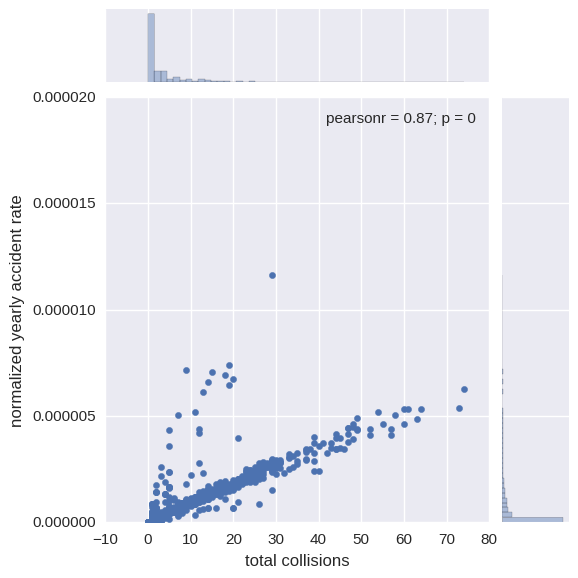

In [480]:
sns.set_context("notebook", font_scale=1.1)
scatter = sns.jointplot(x='total collisions', y = 'normalized yearly accident rate', data = df, ylim= (0,0.00002))

So we'll want to create a prior estimate on what the distribution actually is, using the samples that we have available. In a sense, we're using the data twice. First to estimate our prior. Then we'll use it along with this prior to create a posterior distribution. 

There is a lot of discussion revolving around Full Bayesian analysis, versus Empirical Bayesian Analysis. In some sense, if you know enough about the system you are studying, you should be able to develop a good prior beforehand, rather than using your limited dataset to do so. On the otherhand, imposing beliefs about your system beforehand can be equally controversial to depending on the data twice.

/home/christian/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


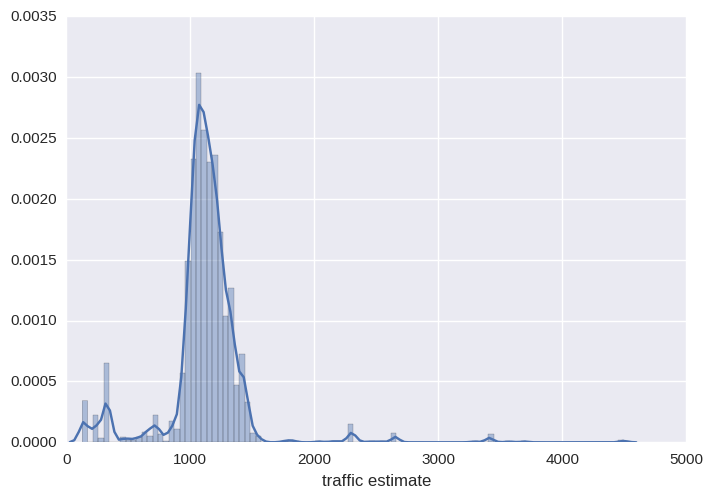

In [481]:
df.to_csv('totals_test.csv')
import scipy.stats as stats
sns.distplot(df["traffic estimate"], bins = 100)

/home/christian/anaconda3/lib/python3.5/site-packages/statsmodels/nonparametric/kdetools.py:20: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  y = X[:m/2+1] + np.r_[0,X[m/2+1:],0]*1j


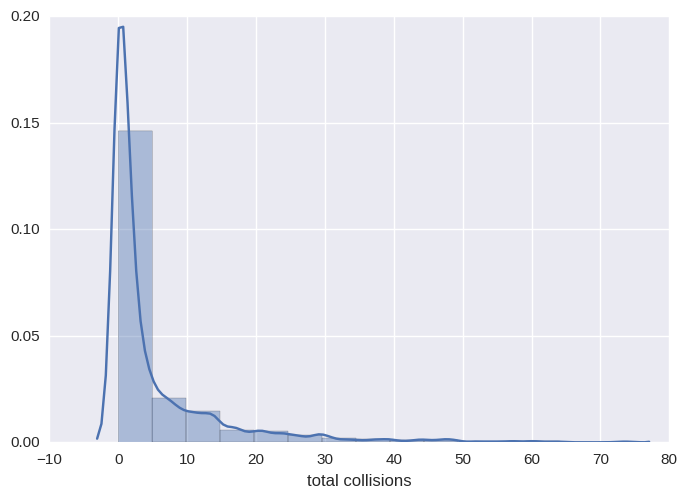

In [482]:
sns.distplot(df["total collisions"], bins = 15)

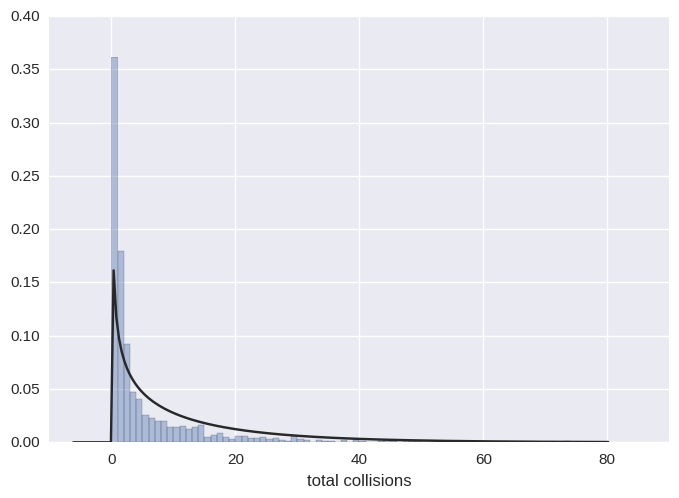

In [483]:
sns.distplot(df["total collisions"], fit=stats.gamma,  bins=range(0, 75, 1), kde=False)

A gamma distribution looks like a good choice to fit our prior. We know that we are dealing with sums of poission distributions where each intersection is basically a poisson process, with the mean accidents for a year being the parameter. So the above histogram is really summing up the number of accidents each year, over these poisson processes. While we could try and fit each intersection individually, this is a whole lot of work. And it's not clear how one would use these estimated parameters to compute the prior distribution for the ensemble. 

A gamma distribution looks nice, and intuitively makes sense since the prior for a poisson distribution is a gamma. Trying to read up on the intuition for how a ensemble of Poisson processes, each with their own paramater (not merely the same), has lead me to some very involved work on Bayesian inference for traffic problems, without directly using machine learning. We won't go that deep in this case though. Suffice to say, there are extensions to the above Poisson model, which attempt to account for the heterogenity of various intersections. The same features one would choose to use in a machine learning approach would show up as parameters in the distribution one tries to fit, and the poisson parameters for each intersection is assumed to be a random variablle, drawn from a chosen distribution

An overview of 3 models which extend our basic method is found in (Miranda-Mereno et al 2005):
http://www.civil.uwaterloo.ca/itss/papers%5C2005-2%20(Alternative%20risk%20models%20for%20ranking%20sites).pdf



In [484]:
stats.gamma.fit(df['total collisions'], loc =0)

(0.43930468201111406, -7.7697069386935107e-32, 15.102836399931292)

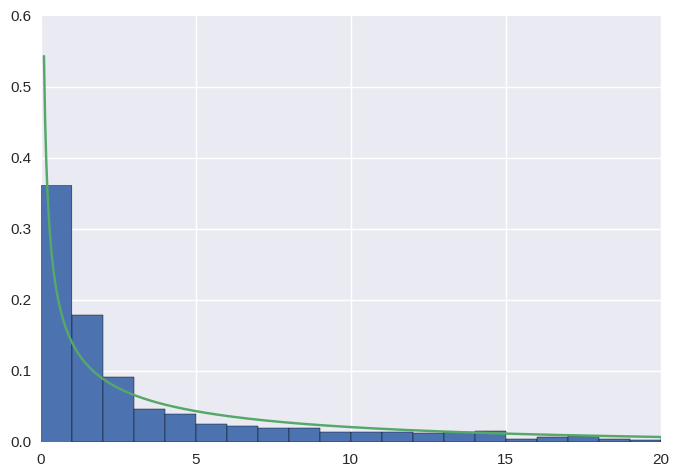

In [485]:
import matplotlib.pylab as plt

#plot normed histogram
plt.hist(df['total collisions'], normed=True,  bins=range(0, 75, 1))

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = 0.1, 75
lnspc = np.linspace(xmin, xmax, len(df))

# exactly same as above
ag,bg,cg = stats.gamma.fit(df['total collisions'], loc=0)  
pdf_gamma = stats.gamma.pdf(lnspc,ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

plt.axis([0,20,0,0.6])
plt.show()

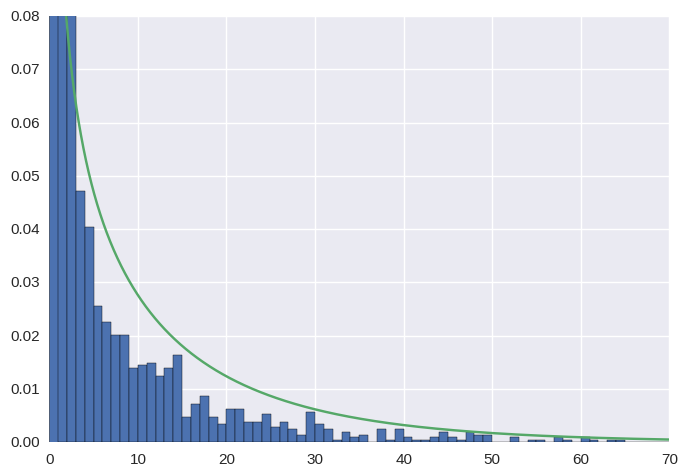

In [486]:
#plot normed histogram
plt.hist(df['total collisions'], normed=True,  bins=range(0, 75, 1))

# find minimum and maximum of xticks, so we know
# where we should compute theoretical distribution
xt = plt.xticks()[0]  
xmin, xmax = 0.1, 75
lnspc = np.linspace(xmin, xmax, len(df))

# exactly same as above
ag,bg,cg = stats.gamma.fit(df['total collisions'])  
pdf_gamma = stats.gamma.pdf(lnspc,ag, bg,cg)  
plt.plot(lnspc, pdf_gamma, label="Gamma")

plt.axis([0,70,0,0.08])
plt.show()

That's a pretty good looking fit. The histogram shows the normalized counts of integer collision totals for our merged dataframe. We can now use the fit paramters of our model, and use this to adjust our estimate of the accident rate.

The mathematics of why the calculation below works to update our estiamte is straight forward to derive from Bayesian probablity theory, but intuitively it just looks likes a weighted average of the prior and sample estimates (when expaneded), where more weight is given to the sample data when the time period is larger, or when the traffic numbers are greater. This makes sense, as in those cases we are MORE confident in our data providing us with a good idea of probability distibution for that intersection.

In [487]:
beta = 1/cg
df['posterior mean'] = (ag + df['total collisions'])/(beta+25*360*df['traffic estimate']) 
df['posterior STD'] = np.sqrt((ag + df['total collisions'])/((beta+25*360*df['traffic estimate'])**2)) 
pd.set_option('display.float_format', '{:.5g}'.format)
df.sort_values(by='posterior mean',ascending = False).head(10)

,normalized yearly accident rate,total collisions,traffic estimate,posterior mean,posterior STD
intersection,,,,,
"Front St W & York St, Toronto, Ontario, M5J",1.1649e-05,29,276.61,1.19e-05,2.1863e-06
"Queens Quay W & Rees St, Toronto, Ontario, M5J",7.1485e-06,9,139.89,7.6438e-06,2.464e-06
"Bay St & Queens Quay W, Toronto, Ontario, M5J",7.3792e-06,19,286.09,7.6214e-06,1.7205e-06
"Station St & York St, Toronto, Ontario, M5J",7.0922e-06,15,235,7.387e-06,1.8689e-06
"Queens Quay W & York St, Toronto, Ontario, M5J",6.9128e-06,18,289.32,7.1523e-06,1.6574e-06
"The Esplanade & Yonge St, Toronto, Ontario, M5E",6.734e-06,20,330,6.944e-06,1.5291e-06
"Lake Shore Blvd W & York St, Toronto, Ontario, M5J",6.6194e-06,14,235,6.9142e-06,1.8081e-06
"Front St W & John St, Toronto, Ontario, M5V",6.469e-06,19,326.34,6.6813e-06,1.5083e-06
"Lake Shore Blvd E & Yonge St, Toronto, Ontario, M5E",6.1466e-06,13,235,6.4414e-06,1.7452e-06


In [488]:
df = df.sort_values(by='total collisions', ascending=False)

In [489]:
df.head()

,normalized yearly accident rate,total collisions,traffic estimate,posterior mean,posterior STD
intersection,,,,,
"Queen St W & Spadina Ave, Toronto, Ontario, M5V",6.2559e-06,74,1314.3,6.3087e-06,7.303e-07
"Bay St & Dundas St W, Toronto, Ontario, M5G",5.393e-06,73,1504,5.4391e-06,6.339e-07
"Queen St W & University Ave, Toronto, Ontario, M5H",5.3153e-06,64,1337.9,5.3671e-06,6.6764e-07
"Bloor St E & Yonge St, Toronto, Ontario, M4W",4.8614e-06,63,1439.9,4.9095e-06,6.1551e-07
"Bathurst St & Queen St W, Toronto, Ontario, M5T",5.3338e-06,61,1270.7,5.3883e-06,6.864e-07


In [490]:
df.to_csv('eba_normalizedcollisions.csv')

So now we have our dataframe with posterior yearly accident rate, as well as a posterior standard deviation. If one looks deeper throughout the data set we see that the order changes slightly, but nothing too crazy. Since we're using so many years of data, the "prior" dominates. The biggest changes are for those intersections that have a very low traffic count, comparatively. Those with high traffic counts have smaller changes. 

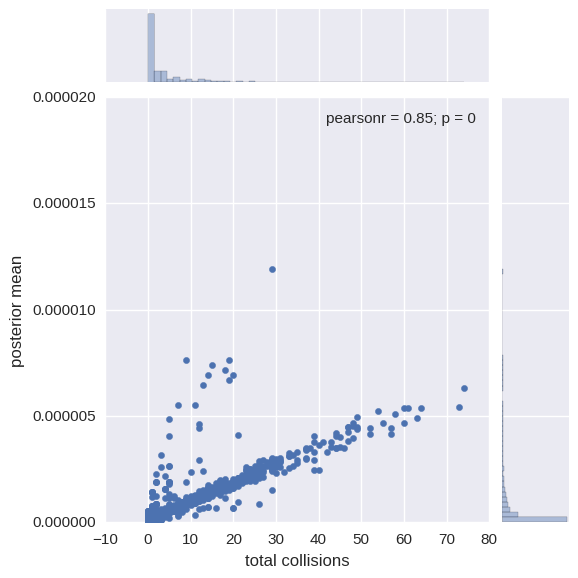

In [491]:
scatter = sns.jointplot(x='total collisions', y = 'posterior mean', data = df, ylim= (0,0.00002))

It is at this point that we may start wondering whether using ALL 25 years of data makes sense. If the predictions are to be for the past year, then surely data closer to this time frame is more applicable. We saw in our exploratory data analysis that there was a total decline in accidents year by year up until 1996. There was a sharp decline in minimal and minor injuries that year, with the slack partly picked up by more "No injuries". Whether this was due to a change in how accidents were classified, or due to the legislation mandating minors to use helmets is hard to say. Likely it could be both! 
![alt text](Screenshot.png "Injuries by year")

After this year however, cycling accidents pick up again. and start looking fairly consistent. Expecially as compared to the first dozen years.
#### It may be that predictive power would improve if we limited the data set to 1998 onwards. This would roughly half our number of starting collisions, but those remaining may be more indicative of current cycling trends. It also avoids that obvious decreasing trend and sudden jump in 96-97. 

Moving forward, we can compare the predicted collision numbers to those observed over the past year, from the Twitterbot. 
We will have a trained model to also compare prediction numbers. One hopes that the increased sophistication of the machine learning approach, using the intersection features which are available, will get closer to the observed data. 

In [585]:
full_df = pd.DataFrame.from_csv('collisions_clean.csv', index_col='ID')

In [629]:
fullgeocoded_df = pd.DataFrame.from_csv('collisions_geocode.csv', index_col ='ID')

In [587]:
full_df.head()

,INJURY,SAFETY EQUIP.,ROAD CLASS,CYCLIST CRASH TYPE,AGE OF CYCLIST,STNAME1,STET 1 TYPE,STNAME 2,STET 2 TYPE,LONG,...,ACC TIME,ACC TIME2,TRAFFIC CONTROL,ROAD SURFACE2,DATE,DATE2,DRIVER ACTION,DRIVER CONDITION,YEAR,INTERSECTION
ID,,,,,,,,,,,,,,,,,,,,,
1,Minimal,Unrecorded,Minor Arterial,Unrecorded,34,BIRCHMOUNT,RD,HIGHVIEW,AV,-79.265,...,1000,10:00:00,stop sign,wet,1986/01/12,1986/01/12,Failed to yield right-of-way,Normal,1986,"Birchmount Rd & Highview Ave, Toronto, Ontario..."
4,Minimal,Unrecorded,Local,Unrecorded,34,EUCLID,AV,ULSTER,ST,-79.413,...,800,08:00:00,no control,loose snow,1986/01/14,1986/01/14,Lost control,Normal,1986,"Euclid Ave & Harbord St, Toronto, Ontario, M6G"
8,Minor,Unrecorded,Major Arterial,Unrecorded,24,DUNDAS,ST,BEVERLEY,ST,-79.394,...,800,08:00:00,traffic signal,wet,1986/01/16,1986/01/16,Failed to yield right-of-way,Normal,1986,"Dundas St W & Beverley St, Toronto, Ontario, M5T"
2,Minimal,Unrecorded,Major Arterial,Unrecorded,54,LAKE SHORE,BLVD,THIRTY-FIFTH,ST,-79.535,...,1000,10:00:00,no control,wet,1986/01/19,1986/01/19,Improper turn,Normal,1986,"Lake Shore Blvd W & 35th St, Toronto, Ontario,..."
3,Minor,Unrecorded,Major Arterial,Unrecorded,19,LAWRENCE,AV,FORTUNE,GATE,-79.218,...,1500,15:00:00,no control,dry,1986/01/23,1986/01/23,Failed to yield right-of-way,Normal,1986,"Lawrence Ave E & Fortune Gate, Toronto, Ontari..."


In [630]:
fullgeocoded_df= fullgeocoded_df.rename(columns = {'INTERSECTION':'intersection'}) 

col_df = fullgeocoded_df.sort_index()
all_realintersections_df = pd.DataFrame.from_csv('real_reversegeocoded.csv')
all_realintersections_df= all_realintersections_df.rename(columns = {'arcgis_int':'intersection'}) 

from numpy import random
from scipy.spatial import distance
import matplotlib.path as mplPath
import numpy as np

#We want to follow a standard intersection convention to make our life easier. 
#Unfortunately the free geocoder with unlimited request numbers per day doesn't see mto follow one of it's own. 
#So we will get the intersections, strip out the two streets, and order them alphabetically.
st2 = col_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post = col_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 = col_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str) and isinstance(pair[1],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1]) + ', ' +str(pair2[2])
    intersection_list.append(intersection)

col_df['intersection'] = intersection_list
    
st2 = all_realintersections_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post =  all_realintersections_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 =  all_realintersections_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1] + ', ' +str(pair2[2]))
    intersection_list.append(intersection)
    
all_realintersections_df['intersection'] = intersection_list
all_realintersections_df.head()  

,intersec5,elev_id,classifi6,classifi7,num_elev,elevatio9,elevatio10,elev_level,elevation,elevatio13,height_r14,height_r15,x_coord,y_coord,longitude,latitude,objectid,intersection
int_id,,,,,,,,,,,,,,,,,,
20041183,Allingham Gdns / Ln N Wilson W Collinson,29125,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.094e+05,4.8438e+06,-79.443,43.736,32028,"Allingham Gdns & King High Ave, Toronto, Ontar..."
14045679,Ln N Annette E Beresford / Ln S St Johns W Run...,17094,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.0633e+05,4.8354e+06,-79.481,43.66,44986,"Annette St & Runnymede Rd, Toronto, Ontario, M6S"
14665974,Byng Ave / Ln 2 N Newport W Byng,22281,LSRML,Lesser-Multi Level,1,501700,Laneway,0,0,NaN,0,NaN,3.2236e+05,4.8395e+06,-79.282,43.697,51026,"Byng Ave & Prairie Dr, Toronto, Ontario, M1L"
13465351,Durie St / Ln E Durie S St Johns / Ln E Winder...,7655,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.0618e+05,4.8353e+06,-79.483,43.66,32868,"Annette St & Durie St, Toronto, Ontario, M6S"
13459936,Luttrell Ave / Ln 2 S Danforth E Luttrell / Ln...,25170,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.2145e+05,4.8385e+06,-79.293,43.689,85370,"Drummondville Ln & Flagman St, Toronto, Ontari..."


In [631]:
central_realintersections_df = pd.DataFrame.from_csv('central_real_intersections.csv')
central_realintersections_df= all_realintersections_df.rename(columns = {'arcgis_int':'intersection'}) 
central_col_df = pd.DataFrame.from_csv('toronto_cycling_central_mode.csv', index_col='id')
from numpy import random
from scipy.spatial import distance
import matplotlib.path as mplPath
import numpy as np

#We want to follow a standard intersection convention to make our life easier. 
#Unfortunately the free geocoder with unlimited request numbers per day doesn't see mto follow one of it's own. 
#So we will get the intersections, strip out the two streets, and order them alphabetically.
st2 = central_col_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post = central_col_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 = central_col_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str) and isinstance(pair[1],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1]) + ', ' +str(pair2[2])
    intersection_list.append(intersection)

central_col_df['intersection'] = intersection_list
    
st2 = central_realintersections_df['intersection'].str.split('&').str.get(1)
st2 =st2.str.split(', Toronto').str[0].str.strip()

post =  central_realintersections_df['intersection'].str.split('&').str.get(1)
post = post.str.partition(', ')[2].str.strip()

st1 =  central_realintersections_df['intersection'].str.split('&').str[0]
st1 = st1.str.strip()

intersection_list = []
streets = pd.concat([st1,st2,post],axis=1)
streets = streets.values.tolist()
streets
for pair in streets:
    if isinstance(pair[0],str):
        if pair[1] <= pair[0]:
            temp = pair[0]
            pair[0] = pair[1]
            pair[1] = temp
for pair2 in streets:
    intersection = str(pair2[0]) + ' & ' + str(pair2[1] + ', ' +str(pair2[2]))
    intersection_list.append(intersection)
    
central_realintersections_df['intersection'] = intersection_list
central_realintersections_df.head()  

,intersec5,elev_id,classifi6,classifi7,num_elev,elevatio9,elevatio10,elev_level,elevation,elevatio13,height_r14,height_r15,x_coord,y_coord,longitude,latitude,objectid,intersection
int_id,,,,,,,,,,,,,,,,,,
20041183,Allingham Gdns / Ln N Wilson W Collinson,29125,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.094e+05,4.8438e+06,-79.443,43.736,32028,"Allingham Gdns & King High Ave, Toronto, Ontar..."
14045679,Ln N Annette E Beresford / Ln S St Johns W Run...,17094,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.0633e+05,4.8354e+06,-79.481,43.66,44986,"Annette St & Runnymede Rd, Toronto, Ontario, M6S"
14665974,Byng Ave / Ln 2 N Newport W Byng,22281,LSRML,Lesser-Multi Level,1,501700,Laneway,0,0,NaN,0,NaN,3.2236e+05,4.8395e+06,-79.282,43.697,51026,"Byng Ave & Prairie Dr, Toronto, Ontario, M1L"
13465351,Durie St / Ln E Durie S St Johns / Ln E Winder...,7655,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.0618e+05,4.8353e+06,-79.483,43.66,32868,"Annette St & Durie St, Toronto, Ontario, M6S"
13459936,Luttrell Ave / Ln 2 S Danforth E Luttrell / Ln...,25170,LSRML,Lesser-Multi Level,2,501700,Laneway,0,0,NaN,0,NaN,3.2145e+05,4.8385e+06,-79.293,43.689,85370,"Drummondville Ln & Flagman St, Toronto, Ontari..."


In [632]:
ped_counts_df = pd.DataFrame.from_csv('Vehicle and Pedestrian Counts/TrafficPedestrianVolumes_2011.csv')

#Using the Power fit for the Bike/Pedestrian ratio, we get a function that predicts the bike numbers at any one intersection.

ped_counts_df['bike_prediction'] = (500.2146799711*ped_counts_df['8HrPedVol']**(-0.8950759596))*ped_counts_df['8HrPedVol']
ped_coords = ped_counts_df[['Latitude','Longitude']]
ped_coords = ped_coords.replace(np.nan,0)
ped_coordinate_list = ped_coords.values.tolist()
ped_counts_df['coordinates'] = ped_counts_df[['Latitude','Longitude']].apply(tuple, axis=1)
ped_counts_df.head()

,Main,Midblock Route,Side 1 Route,Side 2 Route,Activation Date,Latitude,Longitude,Count Date,8HrPedVol,8HrVehVol,24HrPedVol,24HrVehVol,bike_prediction,coordinates
PX2,,,,,,,,,,,,,,
2,JARVIS ST,NaN,FRONT ST E,NaN,1948/11/15,43.649,-79.371,2011/09/08,17008,19335,34016,38670,1390.1,"(43.64945, -79.37141)"
3,KING ST E,NaN,JARVIS ST,NaN,1950/08/23,43.65,-79.372,2011/09/07,37719,17665,75438,35330,1511.3,"(43.6504606, -79.3719239)"
4,JARVIS ST,NaN,ADELAIDE ST E,NaN,1958/09/12,43.652,-79.372,2008/06/16,1991,19726,3982,39452,1110,"(43.6515337, -79.37236)"
5,JARVIS ST,NaN,RICHMOND ST E,NaN,1962/04/21,43.653,-79.373,2009/07/30,2696,24842,5392,49684,1145.8,"(43.6527176, -79.372824)"
6,JARVIS ST,NaN,QUEEN ST E,NaN,1928/08/24,43.654,-79.373,2011/05/18,3622,19772,7244,39544,1181.9,"(43.653704, -79.373238)"


In [633]:
bike_dict = ped_counts_df.set_index('coordinates').to_dict()['bike_prediction']
ped_dict = ped_counts_df.set_index('coordinates').to_dict()['8HrPedVol']
veh_dict = ped_counts_df.set_index('coordinates').to_dict()['8HrVehVol']
col_df['coordinates'] = col_df[['LAT','LONG']].apply(tuple, axis=1)
col_df.head()
all_realintersections_df['coordinates'] = all_realintersections_df[['latitude','longitude']].apply(tuple, axis=1)
equiv = {'Laneway':3,'Minor':2,'Major':1}
all_realintersections_df['num_class'] = all_realintersections_df['elevatio10'].map(equiv)
all_realintersections_df= all_realintersections_df.sort_values(by=['intersection','num_class'])
#take the lowest numerical class, drop the other duplicates. 
all_realintersections_df = all_realintersections_df.drop_duplicates(subset='intersection', keep='first')

central_col_df['coordinates'] = central_col_df[['lat','long']].apply(tuple, axis=1)
central_col_df.head()
central_realintersections_df['coordinates'] = central_realintersections_df[['latitude','longitude']].apply(tuple, axis=1)
equiv = {'Laneway':3,'Minor':2,'Major':1}
central_realintersections_df['num_class'] = central_realintersections_df['elevatio10'].map(equiv)
central_realintersections_df= central_realintersections_df.sort_values(by=['intersection','num_class'])
#take the lowest numerical class, drop the other duplicates. 
central_realintersections_df = central_realintersections_df.drop_duplicates(subset='intersection', keep='first')


In [639]:
import csv
closest_traffic_point = []
bike_traffic = []
veh_traffic = []
ped_traffic = []
i = 0
for i in range(0,len(col_df)):
    point = col_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(bike_dict[tuple(closest)])
    closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
    veh_traffic.append(veh_dict[tuple(closest)])
    ped_traffic.append(ped_dict[tuple(closest)])
    
myfile3 = open('closest_intersection.csv', 'w')
wr = csv.writer(myfile3)
wr.writerow(closest_traffic_point)
myfile3.close()

myfile4 = open('closest_int_bike_predictions.csv', 'w')
wr = csv.writer(myfile4)
wr.writerow(bike_traffic)
myfile4.close()

col_df['closest_traffic'] = tuple(closest_traffic_point)
col_df['traffic_count'] = bike_traffic
col_df['vehicle_traffic'] = veh_traffic
col_df['pedestrian_traffic'] = ped_traffic


col_df= col_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})
col_df.head()

,INJURY,SAFETY EQUIP.,ROAD CLASS,CYCLIST CRASH TYPE,AGE OF CYCLIST,STNAME1,STET 1 TYPE,STNAME 2,STET 2 TYPE,LONG,...,DRIVER ACTION,DRIVER CONDITION,YEAR,intersection,coords,coordinates,closest_ped_count,predicted_bike_count,vehicle_traffic,pedestrian_traffic
ID,,,,,,,,,,,,,,,,,,,,,
1,Minimal,Unrecorded,Minor Arterial,Unrecorded,34,BIRCHMOUNT,RD,HIGHVIEW,AV,-79.265,...,Failed to yield right-of-way,Normal,1986,"Birchmount Rd & Highview Ave, Scarborough, Ont...","[43.69993031900049, -79.26520102099965]","(43.69987, -79.26539)","(43.69698680000001, -79.26399)",935.7,13612,391
2,Minimal,Unrecorded,Major Arterial,Unrecorded,54,LAKE SHORE,BLVD,THIRTY-FIFTH,ST,-79.535,...,Improper turn,Normal,1986,"35th St, Etobicoke, Ontario, M8W & Lake Shore ...","[43.594010966000496, -79.53558099599968]","(43.5941, -79.535)","(43.594339100000006, -79.53393200000002)",1081.2,10632,1550
3,Minor,Unrecorded,Major Arterial,Unrecorded,19,LAWRENCE,AV,FORTUNE,GATE,-79.218,...,Failed to yield right-of-way,Normal,1986,"Fortune Gate & Lawrence Ave E, Scarborough, On...","[43.76100029000048, -79.21975067199963]","(43.7614, -79.218)","(43.761009, -79.2197969)",896.49,16769,260
4,Minimal,Unrecorded,Local,Unrecorded,34,EUCLID,AV,ULSTER,ST,-79.413,...,Lost control,Normal,1986,"Euclid Ave & Ulster St, Toronto, Ontario, M6G","[43.65906013500046, -79.41272077799965]","(43.6599, -79.4133)","(43.66055, -79.41466000000001)",1146,8675,2699
5,Minimal,Unrecorded,Major Arterial,Unrecorded,34,AVENUE,AV,DRAYTON,AV,-79.32,...,Other,Normal,1986,"Danforth Ave & Drayton Ave, Toronto, Ontario, M4C","[43.684091,-79.320205]","(43.68403, -79.32041)","(43.683960000000006, -79.32086000000002)",1154.3,14162,2891


In [642]:
import csv
closest_traffic_point = []
bike_traffic = []
veh_traffic = []
ped_traffic = []
i = 0
for i in range(0,len(central_col_df)):
    point = central_col_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(bike_dict[tuple(closest)])
    closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
    veh_traffic.append(veh_dict[tuple(closest)])
    ped_traffic.append(ped_dict[tuple(closest)])
myfile3 = open('central_closest_intersection.csv', 'w')
wr = csv.writer(myfile3)
wr.writerow(closest_traffic_point)
myfile3.close()

myfile4 = open('central_closest_int_bike_predictions.csv', 'w')
wr = csv.writer(myfile4)
wr.writerow(bike_traffic)
myfile4.close()

central_col_df['closest_traffic'] = tuple(closest_traffic_point)
central_col_df['traffic_count'] = bike_traffic
central_col_df['vehicle_traffic'] = veh_traffic
central_col_df['pedestrian_traffic'] = ped_traffic


central_col_df= central_col_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})
central_col_df.head()

,injury,safety_equip,road_class,cyclist_crash_type,age_of_cyclist,stname1,stet_1_type,stname_2,stet_2_type,long,...,driver_action,driver_condition,year,intersection,coords,coordinates,closest_ped_count,predicted_bike_count,vehicle_traffic,pedestrian_traffic
id,,,,,,,,,,,,,,,,,,,,,
5225,Minor,No equipment available,Local,Unrecorded,12,LAKE SHORE,AV,FIRST,ST,-79.353,...,Driving properly,Normal,1989,"1st St & Lakeshore Ave, Toronto, Ontario, M5J","[43.63268055000049, -79.35316095699966]","(43.633, -79.3532)","(43.645257315, -79.35268223700001)",963.53,5622,517
23112,Minimal,No equipment available,Major Arterial,Unrecorded,10,LAKE SHORE,BLVD,FOURTH,ST,-79.502,...,Driving properly,Normal,2000,"4th St & Lakeshore Ave, Toronto, Ontario, M5J","[43.631641010000465, -79.35378070499968]","(43.601600647, -79.5018997192)","(43.60131000000001, -79.50301)",1089.4,8878,1666
1012,Minimal,Unrecorded,Major Arterial,Unrecorded,54,LAKE SHORE,BLVD,FOURTH,ST,-79.502,...,Failed to yield right-of-way,Normal,1986,"4th St & Lakeshore Ave, Toronto, Ontario, M5J","[43.631641010000465, -79.35378070499968]","(43.60146, -79.50208)","(43.60131000000001, -79.50301)",1089.4,8878,1666
7822,Minor,No equipment available,Major Arterial,Unrecorded,25,LAKE SHORE,BLVD,FOURTH,ST,-79.501,...,Other,Normal,1991,"4th St & Lakeshore Ave, Toronto, Ontario, M5J","[43.631641010000465, -79.35378070499968]","(43.6016, -79.5015)","(43.601723299999996, -79.500725)",1070.6,7845,1411
11021,Minimal,No equipment available,Major Arterial,Unrecorded,23,LAKE SHORE,BLVD,FOURTH,ST,-79.501,...,Other,Normal,1993,"4th St & Lakeshore Ave, Toronto, Ontario, M5J","[43.631641010000465, -79.35378070499968]","(43.6016, -79.5015)","(43.601723299999996, -79.500725)",1070.6,7845,1411


In [643]:
import csv
closest_traffic_point = []
bike_traffic = []
veh_traffic = []
ped_traffic = []
i = 0
for i in range(0,len(all_realintersections_df)):
    point = all_realintersections_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(bike_dict[tuple(closest)])
    closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
    veh_traffic.append(veh_dict[tuple(closest)])
    ped_traffic.append(ped_dict[tuple(closest)])   
myfile5 = open('closest_intersection_centreline.csv', 'w')
wr = csv.writer(myfile5)
wr.writerow(closest_traffic_point)
myfile5.close()

myfile6 = open('closest_int_bike_predictions_centreline.csv', 'w')
wr = csv.writer(myfile6)
wr.writerow(bike_traffic)
myfile6.close()

all_realintersections_df['closest_traffic'] = tuple(closest_traffic_point)
all_realintersections_df['traffic_count'] = bike_traffic
all_realintersections_df['vehicle_traffic'] = veh_traffic
all_realintersections_df['pedestrian_traffic'] = ped_traffic

all_realintersections_df = all_realintersections_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})

In [644]:
import csv
closest_traffic_point = []
bike_traffic = []
veh_traffic = []
ped_traffic = []
i = 0
for i in range(0,len(central_realintersections_df)):
    point = central_realintersections_df['coordinates'].iloc[i]
    if waterfront_Path.contains_point(point):
        closest = waterfront[distance.cdist([point], waterfront).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(waterfront_dict[tuple(closest)])
    elif campus_Path.contains_point(point):
        closest = campus[distance.cdist([point], campus).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(campus_dict[tuple(closest)])
    elif castleFrank_Path.contains_point(point):
        closest = castleFrank[distance.cdist([point], castleFrank).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(castleFrank_dict[tuple(closest)])
    else:
        closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
        closest_traffic_point.append(tuple(closest))
        bike_traffic.append(bike_dict[tuple(closest)])
    closest = ped_coordinate_list[distance.cdist([point], ped_coordinate_list).argmin()]
    veh_traffic.append(veh_dict[tuple(closest)])
    ped_traffic.append(ped_dict[tuple(closest)])   
myfile5 = open('central_closest_intersection_centreline.csv', 'w')
wr = csv.writer(myfile5)
wr.writerow(closest_traffic_point)
myfile5.close()

myfile6 = open('central_closest_int_bike_predictions_centreline.csv', 'w')
wr = csv.writer(myfile6)
wr.writerow(bike_traffic)
myfile6.close()

central_realintersections_df['closest_traffic'] = tuple(closest_traffic_point)
central_realintersections_df['traffic_count'] = bike_traffic
central_realintersections_df['vehicle_traffic'] = veh_traffic
central_realintersections_df['pedestrian_traffic'] = ped_traffic

central_realintersections_df = central_realintersections_df.rename(columns={'closest_traffic': 'closest_ped_count', 'traffic_count':'predicted_bike_count'})

In [645]:
all_realint_df = all_realintersections_df[['intersection','coordinates','closest_ped_count','predicted_bike_count','vehicle_traffic','pedestrian_traffic','elevatio10']]
#all_realint_df.sort_values(by='predicted_bike_count')

result = pd.merge(col_df,all_realint_df, how ='outer',on='intersection')
result = result.sort_values(by='intersection')
traff2 =result['predicted_bike_count_y']
traff2.fillna(1,inplace=True)
result['predicted_bike_count_x'] =result['predicted_bike_count_x'].fillna(value = traff2 )

In [646]:
central_realint_df = central_realintersections_df[['intersection','coordinates','closest_ped_count','predicted_bike_count','vehicle_traffic','pedestrian_traffic','elevatio10']]
#all_realint_df.sort_values(by='predicted_bike_count')

result_central = pd.merge(central_col_df,central_realint_df, how ='outer',on='intersection')
result_central = result_central.sort_values(by='intersection')
traff_c =result_central['predicted_bike_count_y']
result_central['predicted_bike_count_x'] =result_central['predicted_bike_count_x'].fillna(value = traff_c )

In [647]:
injury_df = full_df[full_df['YEAR'] >1997].groupby('INJURY').size()
total = injury_df.sum()
d = {'injury': pd.Series([total/31,total/543,total/5575,total/(7171+2039)], index=['Fatal','Major','Minor','Minimal'])}
inverse_df = pd.DataFrame(d)
inverse_df = inverse_df/inverse_df.loc['Minimal']
inverse_df

,injury
Fatal,297.1
Major,16.961
Minor,1.652
Minimal,1


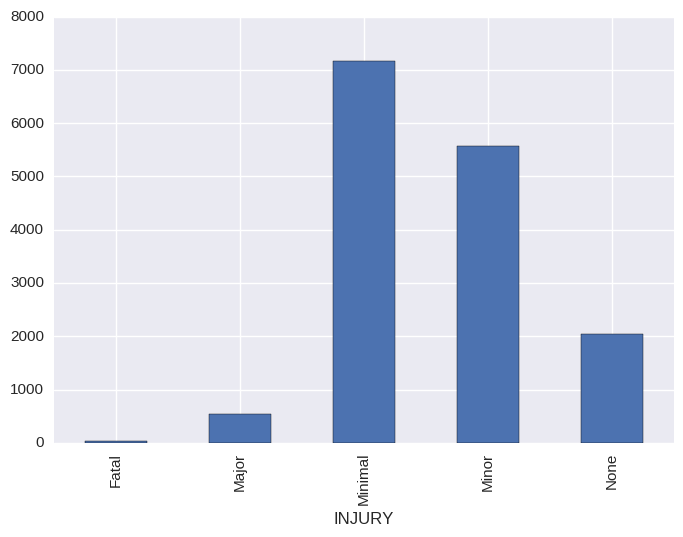

In [648]:
injury_df.plot(kind='bar')

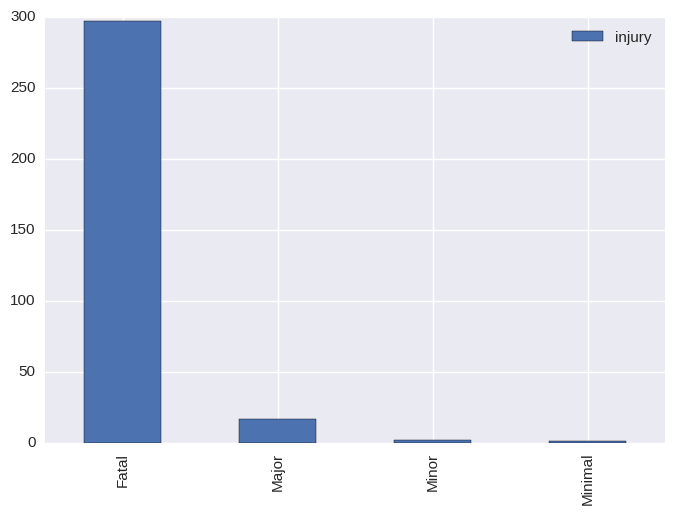

In [649]:
inverse_df.plot(kind='bar')

Filtering past 1997 got ridd of the "unrecorded" entries, so that's a helpful. Now combined 'minimal' and 'none' into one category. This is because we are going to estimate a "risk factor" for each intersection, where major accidents are worth more than a minor accident, which are worth more than a minor etc. In treating a 'none' it seems simplest to compine this with 'minimal' accidents, so we can merely just invert our data to get our weighting factors. 

It can be difficult and subjective to make this sort of call. How is the loss of a human life (for fatal accidents), numerically compared to that in which a minor accident occurs? Obviously more serious accidents should be percieved as more dangerous. We are letting the data provide this estimate for us. We will merely compare the relative sizes of each. 

This may not seem neccessary, as working off the raw collision numbers and normalizing those may feel more intuitive to some. However, I believe that when we run our algorithm against new data (Nov 2015 to Nov 2016), an algorithm which weighs these different accident types will make better predictions. Unfortunately it will not be an apples to apples comparison. To do this, one would like to know the severity of accidents in our test data as well. The twitter bot does not make this distinction clear. But it is merely retweeting collisions reported by the Toronto police twitter app, which is not the same as having access to the filed police reports of the Toronto Police database. One would then believe that our new data is made up of more serious collisions, as the police were immediately informed.

In [650]:
injury_dict = inverse_df.to_dict()

In [654]:
injury_dict['None']=1.0
injury_dict = injury_dict
col_df['injury_num'] = col_df['INJURY'].map(injury_dict) 
col_df['injury_num'] = col_df['injury_num'].fillna(value=0)
central_col_df['injury_num'] = central_col_df['injury'].map(injury_dict) 
central_col_df['injury_num'] = central_col_df['injury_num'].fillna(value=0)

In [672]:
len(intersection_df)

1106

In [655]:
#result.to_csv('merged_data.csv')
new_col = col_df[col_df['YEAR']>1997]

result = pd.merge(new_col,all_realint_df, how ='outer',on='intersection')
result = result.sort_values(by='intersection')

severity_df = pd.get_dummies(new_col.INJURY, dummy_na=False)
new_col = pd.concat([new_col,severity_df],axis=1)
new_col['Minimal/None'] = new_col['Minimal'] + new_col['None']
intersection_df = new_col.groupby('intersection').agg({'predicted_bike_count':[np.size,np.mean],'vehicle_traffic':[np.mean],'pedestrian_traffic':[np.mean],'injury_num':[np.sum],'Fatal':[np.sum],'Major':[np.sum],'Minor':[np.sum],'Minimal/None':[np.sum]}).sort_values(by=[('predicted_bike_count','size')],ascending=False)
intersection_df.columns = intersection_df.columns.set_levels(['minor','predicted_bike_count','injury_num','pedestrian_traffic','fatal','minimal/none','major','vehicle_traffic'], level=0)
zeroes_df = all_realint_df.groupby('intersection').agg({'predicted_bike_count':[np.size,np.mean],'vehicle_traffic':[np.mean],'pedestrian_traffic':[np.mean]}).sort_values(by=[('predicted_bike_count','size')],ascending=False)
zeroes_df['predicted_bike_count','size'] = 0
zeroes_df['injury_num','sum'] = 0
#Let's use 360 as the days in the year. It's a nice round number. And since weekends are less busy it's probably still an overestimate.
zeroes_df['Rates','normalized_accident_rate'] = zeroes_df['predicted_bike_count','size']/(13*360*zeroes_df['predicted_bike_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('Rates','normalized_accident_rate')],ascending=False)
intersection_df['Rates','normalized_accident_rate'] = intersection_df['predicted_bike_count','size']/(13*360*intersection_df['predicted_bike_count','mean'])
intersection_df = intersection_df.sort_values(by=[('Rates','normalized_accident_rate')],ascending=False)

zeroes_df['Rates','normalized_risk_factor'] = zeroes_df['injury_num','sum']/(13*360*zeroes_df['predicted_bike_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('Rates','normalized_risk_factor')],ascending=False)
intersection_df['Rates','normalized_risk_factor'] = intersection_df['injury_num','sum']/(13*360*intersection_df['predicted_bike_count','mean'])
intersection_df = intersection_df.sort_values(by=[('Rates','normalized_risk_factor')],ascending=False)

totals_df = pd.concat([intersection_df,zeroes_df])
df_test = totals_df['Rates','normalized_accident_rate']
df_data2 = df_test.to_frame(name='normalized yearly accident rate')
df_data2['total collisions'] = totals_df['predicted_bike_count','size']
df_data2['bike traffic estimate'] = totals_df['predicted_bike_count','mean']
df_data2['scaled collisions'] = totals_df['injury_num','sum']
df_data2['normalized_risk_factor'] = totals_df['Rates','normalized_risk_factor']
df_data2['vehicle traffic'] = totals_df['vehicle_traffic']
df_data2['pedestrian traffic'] = totals_df['pedestrian_traffic']
df_data2['fatal'] = totals_df['fatal']
df_data2['major'] = totals_df.major
df_data2['minor'] = totals_df.minor
df_data2['minimal/none'] = totals_df['minimal/none']
df_data2['normalized yearly accident rate'].fillna(0,inplace=True)
df_data2['normalized_risk_factor'].fillna(0,inplace=True)
df_data2.fillna(0,inplace=True)
df_data2.dropna(inplace=True)
#Here we make the index a column, drop the duplicates from this intersection column, then make it the index again. 
df_data2 = df_data2.reset_index().drop_duplicates(subset='intersection', keep='first').set_index('intersection')
df_data2 = df_data2.sort_values(by='total collisions',ascending=False)
len(df_data2)

20371

In [658]:
#result.to_csv('merged_data.csv')
new_col_central = central_col_df[central_col_df['year']>1997]

result_central = pd.merge(new_col_central,central_realint_df, how ='outer',on='intersection')
result_central = result_central.sort_values(by='intersection')

severity_df = pd.get_dummies(new_col_central.injury, dummy_na=False)
new_col_central = pd.concat([new_col_central,severity_df],axis=1)
new_col_central['Minimal/None'] = new_col_central['Minimal'] + new_col_central['None']
intersection_df = new_col_central.groupby('intersection').agg({'predicted_bike_count':[np.size,np.mean],'vehicle_traffic':[np.mean],'pedestrian_traffic':[np.mean],'injury_num':[np.sum],'Fatal':[np.sum],'Major':[np.sum],'Minor':[np.sum],'Minimal/None':[np.sum]}).sort_values(by=[('predicted_bike_count','size')],ascending=False)
intersection_df.columns = intersection_df.columns.set_levels(['minor','predicted_bike_count','injury_num','pedestrian_traffic','fatal','minimal/none','major','vehicle_traffic'], level=0)
zeroes_df = central_realint_df.groupby('intersection').agg({'predicted_bike_count':[np.size,np.mean],'vehicle_traffic':[np.mean],'pedestrian_traffic':[np.mean]}).sort_values(by=[('predicted_bike_count','size')],ascending=False)
zeroes_df['predicted_bike_count','size'] = 0
zeroes_df['injury_num','sum'] = 0
#Let's use 360 as the days in the year. It's a nice round number. And since weekends are less busy it's probably still an overestimate.
zeroes_df['Rates','normalized_accident_rate'] = zeroes_df['predicted_bike_count','size']/(13*360*zeroes_df['predicted_bike_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('Rates','normalized_accident_rate')],ascending=False)
intersection_df['Rates','normalized_accident_rate'] = intersection_df['predicted_bike_count','size']/(13*360*intersection_df['predicted_bike_count','mean'])
intersection_df = intersection_df.sort_values(by=[('Rates','normalized_accident_rate')],ascending=False)

zeroes_df['Rates','normalized_risk_factor'] = zeroes_df['injury_num','sum']/(13*360*zeroes_df['predicted_bike_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('Rates','normalized_risk_factor')],ascending=False)
intersection_df['Rates','normalized_risk_factor'] = intersection_df['injury_num','sum']/(13*360*intersection_df['predicted_bike_count','mean'])
intersection_df = intersection_df.sort_values(by=[('Rates','normalized_risk_factor')],ascending=False)

totals_df = pd.concat([intersection_df,zeroes_df])
df_test = totals_df['Rates','normalized_accident_rate']
df_data_central = df_test.to_frame(name='normalized yearly accident rate')
df_data_central['total collisions'] = totals_df['predicted_bike_count','size']
df_data_central['bike traffic estimate'] = totals_df['predicted_bike_count','mean']
df_data_central['scaled collisions'] = totals_df['injury_num','sum']
df_data_central['normalized_risk_factor'] = totals_df['Rates','normalized_risk_factor']
df_data_central['vehicle traffic'] = totals_df['vehicle_traffic']
df_data_central['pedestrian traffic'] = totals_df['pedestrian_traffic']
df_data_central['fatal'] = totals_df['fatal']
df_data_central['major'] = totals_df.major
df_data_central['minor'] = totals_df.minor
df_data_central['minimal/none'] = totals_df['minimal/none']
df_data_central['normalized yearly accident rate'].fillna(0,inplace=True)
df_data_central['normalized_risk_factor'].fillna(0,inplace=True)
df_data_central.fillna(0,inplace=True)
df_data_central.dropna(inplace=True)
#Here we make the index a column, drop the duplicates from this intersection column, then make it the index again. 
df_data_central = df_data_central.reset_index().drop_duplicates(subset='intersection', keep='first').set_index('intersection')
df_data_central = df_data_central.sort_values(by='total collisions',ascending=False)
len(df_data_central)

18693

In [668]:
df_data2.head()

,normalized yearly accident rate,total collisions,bike traffic estimate,scaled collisions,normalized_risk_factor,vehicle traffic,pedestrian traffic,fatal,major,minor,minimal/none
intersection,,,,,,,,,,,
"Queen St W & Spadina Ave, Toronto, Ontario, M5V",7.0407e-06,43,1305,4,6.5495e-07,22206,9791.5,0,2,15,26
"Bathurst St & Bloor St W, Toronto, Ontario, M5R",6.5778e-06,41,1331.9,7,1.123e-06,22976,11309,0,1,20,20
"Bathurst St & Queen St W, Toronto, Ontario, M5T",6.7557e-06,40,1265.2,6,1.0134e-06,17330,7338.1,0,0,18,22
"Bay St & Dundas St W, Toronto, Ontario, M5G",5.264e-06,37,1501.9,4,5.6909e-07,20558,37431,0,0,13,24
"Queen St W & University Ave, Toronto, Ontario, M5H",5.8533e-06,37,1350.7,6,9.4918e-07,29023,14508,0,1,7,29


# SKIP CELL BELOW!

In [278]:
result2.to_csv('merged_data2.csv')
new_col = central_col_df[central_col_df['year']>1997]

central_realint_df = central_realintersections_df[['intersection','coordinates','closest_traffic','traffic_count','elevatio10']]
central_realint_df.sort_values(by='traffic_count')

result = pd.merge(new_col,central_realint_df, how ='outer',on='intersection')
result = result.sort_values(by='intersection')

severity_df = pd.get_dummies(new_col.injury, dummy_na=False)
new_col = pd.concat([new_col,severity_df],axis=1)
new_col['Minimal/None'] = new_col['Minimal'] + new_col['None']
intersection_df = new_col.groupby('intersection').agg({'traffic_count':[np.size,np.mean],'injury_num':[np.sum],'Fatal':[np.sum],'Major':[np.sum],'Minor':[np.sum],'Minimal/None':[np.sum]}).sort_values(by=[('traffic_count','size')],ascending=False)
intersection_df.columns = intersection_df.columns.set_levels(['minor', 'traffic_count','fatal','minimal/none','major','injury_num'], level=0)
zeroes_df = central_realint_df.groupby('intersection').agg({'traffic_count':[np.size,np.mean]}).sort_values(by=[('traffic_count','size')],ascending=False)
zeroes_df['traffic_count','size'] = 0
zeroes_df['injury_num','sum'] = 0
#Let's use 360 as the days in the year. It's a nice round number. And since weekends are less busy it's probably still an overestimate.
zeroes_df['traffic_count','normalized_accident_rate'] = zeroes_df['traffic_count','size']/(13*360*zeroes_df['traffic_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('traffic_count','normalized_accident_rate')],ascending=False)
intersection_df['traffic_count','normalized_accident_rate'] = intersection_df['traffic_count','size']/(13*360*intersection_df['traffic_count','mean'])
intersection_df = intersection_df.sort_values(by=[('traffic_count','normalized_accident_rate')],ascending=False)

zeroes_df['traffic_count','normalized_risk_factor'] = zeroes_df['injury_num','sum']/(13*360*zeroes_df['traffic_count','mean'])
zeroes_df = zeroes_df.sort_values(by=[('traffic_count','normalized_risk_factor')],ascending=False)
intersection_df['traffic_count','normalized_risk_factor'] = intersection_df['injury_num','sum']/(13*360*intersection_df['traffic_count','mean'])
intersection_df = intersection_df.sort_values(by=[('traffic_count','normalized_risk_factor')],ascending=False)

totals_df = pd.concat([intersection_df,zeroes_df])
df_test = totals_df['traffic_count','normalized_accident_rate']
df_data = df_test.to_frame(name='normalized yearly accident rate')
df_data['total collisions'] = totals_df['traffic_count','size']
df_data['traffic estimate'] = totals_df['traffic_count','mean']
df_data['scaled collisions'] = totals_df['injury_num','sum']
df_data['normalized_risk_factor'] = totals_df['traffic_count','normalized_risk_factor']
df_data['fatal'] = totals_df['fatal']
df_data['major'] = totals_df.major
df_data['minor'] = totals_df.minor
df_data['minimal/none'] = totals_df['minimal/none']
#df_data = df_data.dropna()
#Here we make the index a column, drop the duplicates from this intersection column, then make it the index again. 
df_data = df_data.reset_index().drop_duplicates(subset='intersection', keep='first').set_index('intersection')
df_data = df_data.sort_values(by='total collisions',ascending=False)
len(df_data)

2047

In [669]:
df_data2.to_csv('all_totals.csv')
df_data_central.to_csv('central_totals.csv')

In [ ]:
result

In [678]:
temp = result
temp = temp.replace(np.nan,-1)
roadclass_df =temp.groupby(['intersection']+['ROAD CLASS']) \
            .size().to_frame('count') \
            .reset_index().sort_values('intersection',ascending=False)
                
#roadclass_df['road_class'] =roadclass_df['road_class'].fillna(value =elevatio_df)
roadclass_df = roadclass_df.sort_values('count', ascending=False)
roadclass_df = roadclass_df.replace(np.nan,-1)     
roadclass_dict = {'Collector':1, 'Expressway':1,'Expressway Ramp':1,'Major Arterial':2,'Minor Arterial':3,'Local':4, 'Laneway':4, 'Private Property':4}
roadclass_df['roadclass_num'] = roadclass_df['ROAD CLASS'].map(roadclass_dict)
roadclass_df = roadclass_df.sort_values(by = ['intersection','roadclass_num'], ascending = True)
roadclass_df = roadclass_df.drop_duplicates(subset='intersection', keep='first')
roadclass_df = roadclass_df.sort_values(by='intersection', ascending= False)

temp = result
temp['elevatio10'].replace(np.nan,'unrecorded', inplace =True)
elevatio_df =temp.groupby(['intersection']+['elevatio10']) \
            .size().to_frame('count') \
            .reset_index().sort_values('intersection',ascending=False)
        
elevatio10_dict = {'Major':'Major Arterial', 'Minor':'Minor Arterial','Laneway':'Local'}
elevatio_df['intersection_type']= elevatio_df['elevatio10'].map(elevatio10_dict)

elevatio_df = elevatio_df.sort_values(by = ['intersection','intersection_type'], ascending = True)
elevatio_df = elevatio_df.drop_duplicates(subset='intersection', keep='first')
elevatio_df = elevatio_df.sort_values(by='intersection', ascending= False)
elevatio_df.reset_index(inplace = True)
elevatio10 = elevatio_df['intersection_type']

roadclass_df['ROAD CLASS'] =roadclass_df['ROAD CLASS'].replace(to_replace = -1,value = np.nan)
roadclass_df.reset_index(inplace=True)
roadclass_df['ROAD CLASS'] =roadclass_df['ROAD CLASS'].fillna(value = elevatio10)

roadclass_df['roadclass_num'] = roadclass_df['ROAD CLASS'].map(roadclass_dict)
roadclass_df = roadclass_df.sort_values(by = ['intersection','roadclass_num'], ascending = True)
roadclass_df = roadclass_df.drop_duplicates(subset='intersection', keep='first')
roadclass_df = roadclass_df.sort_values(by='intersection', ascending= False)

In [679]:
len(roadclass_df)

20371

In [680]:
roadclass_df.groupby(['ROAD CLASS']).size()

ROAD CLASS
Collector                791
Expressway                23
Expressway Ramp           49
Hydro Line                 1
Laneway                   10
Local                   1104
Major Arterial          2818
Major Arterial Ramp        3
Minor Arterial         15408
Minor Arterial Ramp        1
Other                      4
Private Property         158
River                      1
dtype: int64

In [681]:
result['TRAFFIC CONTROL'].replace(np.nan,'unrecorded', inplace=True)
result['ROAD CLASS'].replace(['Expressway Ramp', 'Hydro Line','Laneway','Major Arterial Ramp','Minor Arterial Ramp','Other','Private Property', 'River'],['Expressway','Local','Local','Major Arterial','Minor Arterial','Local','Local','Local'],inplace=True)
temp = result
trafficcontrol_df =temp.groupby(['intersection']+['TRAFFIC CONTROL']) \
            .size().to_frame('count') \
            .reset_index().sort_values('count',ascending=False)
        
trafficcontrol_dict = {'traffic signal':1, 'traffic gate':1,'traffic controller':1,'stop sign':2, 'yield sign':2, 'pedestrian crossover':3, 'no control':5, 'other':6, 'unrecorded':6,'police control':6,'school bus':6,'school guard':3}
trafficcontrol_df['trafficcontrol_num'] = trafficcontrol_df['TRAFFIC CONTROL'].map(trafficcontrol_dict)
trafficcontrol_df = trafficcontrol_df.sort_values(by = ['intersection','trafficcontrol_num'], ascending = True)
trafficcontrol_df = trafficcontrol_df.drop_duplicates(subset='intersection', keep='first')
trafficcontrol_df = trafficcontrol_df.sort_values(by='intersection', ascending= False)

In [682]:
trafficcontrol_df.to_csv('trafficcontrol_df.csv')

In [683]:
len(trafficcontrol_df)

20371

In [684]:
reverse_dict = {1:'traffic signal/gate',2:'stop/yield sign', 3:'pedestrian crossover',5:'no control', 6:'other/unrecorded'}
trafficcontrol_df['control category'] = trafficcontrol_df['trafficcontrol_num'].map(reverse_dict)

trafficcontrol_df.head()

,intersection,TRAFFIC CONTROL,count,trafficcontrol_num,control category
22146,"bpNichol Ln & bpNichol Ln, Toronto, Ontario, M5S",no control,1,5,no control
22145,"Zachary Ct & Zachary Ct, Toronto, Ontario, M6A",unrecorded,1,6,other/unrecorded
22144,"York Ridge Rd & York Ridge Rd, Toronto, Ontari...",unrecorded,1,6,other/unrecorded
22143,"York Mills Rd & York Ridge Rd, Toronto, Ontari...",unrecorded,1,6,other/unrecorded
22142,"York Mills Rd & York Mills Rd, Toronto, Ontari...",unrecorded,1,6,other/unrecorded


In [685]:
trafficcontrol_df.groupby(['control category']).size()

control category
no control               2172
other/unrecorded        14693
pedestrian crossover       93
stop/yield sign          1702
traffic signal/gate      1711
dtype: int64

In [686]:
reverseROAD_dict = {1:'Collector/Expressway',2:'Major Arterial', 3:'Minor Arterial',4:'Local/Laneway'}
roadclass_df['road_class_cat'] = roadclass_df['roadclass_num'].map(reverseROAD_dict)

roadclass_df.head()

,index,intersection,ROAD CLASS,count,roadclass_num,road_class_cat
0,21209,"bpNichol Ln & bpNichol Ln, Toronto, Ontario, M5S",Major Arterial,1,2,Major Arterial
1,21208,"Zachary Ct & Zachary Ct, Toronto, Ontario, M6A",Local,1,4,Local/Laneway
2,21207,"York Ridge Rd & York Ridge Rd, Toronto, Ontari...",Minor Arterial,1,3,Minor Arterial
3,21206,"York Mills Rd & York Ridge Rd, Toronto, Ontari...",Minor Arterial,1,3,Minor Arterial
4,21205,"York Mills Rd & York Mills Rd, Toronto, Ontari...",Minor Arterial,1,3,Minor Arterial


In [687]:
roadclass_df.groupby(['road_class_cat']).size()

road_class_cat
Collector/Expressway      863
Local/Laneway            1272
Major Arterial           2818
Minor Arterial          15408
dtype: int64

In [688]:
df_data2 = df_data2.sort_index(ascending = False)
df_data2['road_class'] = roadclass_df['road_class_cat'].values
df_data2['control type'] = trafficcontrol_df['control category'].values
df_data2[['fatal','major','minor','minimal/none']] = df_data2[['fatal','major','minor','minimal/none']].fillna(0)

traffdummy_df = pd.get_dummies(df_data2['control type'], dummy_na=False)
df_data2 = pd.concat([df_data2, traffdummy_df ],axis=1)

rdclass_dummy = pd.get_dummies(df_data2['road_class'])
df_data2 = pd.concat([df_data2, rdclass_dummy],axis=1)

In [689]:
df_data2.head()

,normalized yearly accident rate,total collisions,bike traffic estimate,scaled collisions,normalized_risk_factor,vehicle traffic,pedestrian traffic,fatal,major,minor,...,control type,no control,other/unrecorded,pedestrian crossover,stop/yield sign,traffic signal/gate,Collector/Expressway,Local/Laneway,Major Arterial,Minor Arterial
intersection,,,,,,,,,,,,,,,,,,,,,
"bpNichol Ln & bpNichol Ln, Toronto, Ontario, M5S",1.7566e-07,1,1216.4,0,0,11213,4767,0,0,1,...,no control,1,0,0,0,0,0,0,1,0
"Zachary Ct & Zachary Ct, Toronto, Ontario, M6A",0,0,1111.1,0,0,12798,2011,0,0,0,...,other/unrecorded,0,1,0,0,0,0,1,0,0
"York Ridge Rd & York Ridge Rd, Toronto, Ontario, M2P",0,0,783.49,0,0,13638,72,0,0,0,...,other/unrecorded,0,1,0,0,0,0,0,0,1
"York Mills Rd & York Ridge Rd, Toronto, Ontario, M2P",0,0,783.49,0,0,13638,72,0,0,0,...,other/unrecorded,0,1,0,0,0,0,0,0,1
"York Mills Rd & York Mills Rd, Toronto, Ontario, M3B",0,0,1106.1,0,0,25718,1926,0,0,0,...,other/unrecorded,0,1,0,0,0,0,0,0,1


In [690]:
df_data2['bike traffic estimate'].replace(0,1,inplace=True)
df_data2['pedestrian traffic'].replace(0,1,inplace=True)

In [695]:
temp = result_central
temp = temp.replace(np.nan,-1)
roadclass_df =temp.groupby(['intersection']+['road_class']) \
            .size().to_frame('count') \
            .reset_index().sort_values('intersection',ascending=False)
                
#roadclass_df['road_class'] =roadclass_df['road_class'].fillna(value =elevatio_df)
roadclass_df = roadclass_df.sort_values('count', ascending=False)
roadclass_df = roadclass_df.replace(np.nan,-1)     
roadclass_dict = {'Collector':1, 'Expressway':1,'Expressway Ramp':1,'Major Arterial':2,'Minor Arterial':3,'Local':4, 'Laneway':4, 'Private Property':4}
roadclass_df['roadclass_num'] = roadclass_df['road_class'].map(roadclass_dict)
roadclass_df = roadclass_df.sort_values(by = ['intersection','roadclass_num'], ascending = True)
roadclass_df = roadclass_df.drop_duplicates(subset='intersection', keep='first')
roadclass_df = roadclass_df.sort_values(by='intersection', ascending= False)

temp = result_central
temp['elevatio10'].replace(np.nan,'unrecorded', inplace =True)
elevatio_df =temp.groupby(['intersection']+['elevatio10']) \
            .size().to_frame('count') \
            .reset_index().sort_values('intersection',ascending=False)
        
elevatio10_dict = {'Major':'Major Arterial', 'Minor':'Minor Arterial','Laneway':'Local'}
elevatio_df['intersection_type']= elevatio_df['elevatio10'].map(elevatio10_dict)

elevatio_df = elevatio_df.sort_values(by = ['intersection','intersection_type'], ascending = True)
elevatio_df = elevatio_df.drop_duplicates(subset='intersection', keep='first')
elevatio_df = elevatio_df.sort_values(by='intersection', ascending= False)
elevatio_df.reset_index(inplace = True)
elevatio10 = elevatio_df['intersection_type']

roadclass_df['ROAD CLASS'] =roadclass_df['road_class'].replace(to_replace = -1,value = np.nan)
roadclass_df.reset_index(inplace=True)
roadclass_df['ROAD CLASS'] =roadclass_df['ROAD CLASS'].fillna(value = elevatio10)

roadclass_df['roadclass_num'] = roadclass_df['ROAD CLASS'].map(roadclass_dict)
roadclass_df = roadclass_df.sort_values(by = ['intersection','roadclass_num'], ascending = True)
roadclass_df = roadclass_df.drop_duplicates(subset='intersection', keep='first')
roadclass_df = roadclass_df.sort_values(by='intersection', ascending= False)

roadclass_df.groupby(['ROAD CLASS']).size()

ROAD CLASS
Collector             169
Expressway              6
Expressway Ramp         5
Laneway                 3
Local                 469
Major Arterial        761
Minor Arterial      17275
Private Property        5
dtype: int64

In [698]:
result_central['traffic_control'].replace(np.nan,'unrecorded', inplace=True)
result_central['road_class'].replace(['Expressway Ramp', 'Hydro Line','Laneway','Major Arterial Ramp','Minor Arterial Ramp','Other','Private Property', 'River'],['Expressway','Local','Local','Major Arterial','Minor Arterial','Local','Local','Local'],inplace=True)
temp = result_central
trafficcontrol_df =temp.groupby(['intersection']+['traffic_control']) \
            .size().to_frame('count') \
            .reset_index().sort_values('count',ascending=False)
        
trafficcontrol_dict = {'traffic signal':1, 'traffic gate':1,'traffic controller':1,'stop sign':2, 'yield sign':2, 'pedestrian crossover':3, 'no control':5, 'other':6, 'unrecorded':6,'police control':6,'school bus':6,'school guard':3}
trafficcontrol_df['trafficcontrol_num'] = trafficcontrol_df['traffic_control'].map(trafficcontrol_dict)
trafficcontrol_df = trafficcontrol_df.sort_values(by = ['intersection','trafficcontrol_num'], ascending = True)
trafficcontrol_df = trafficcontrol_df.drop_duplicates(subset='intersection', keep='first')
trafficcontrol_df = trafficcontrol_df.sort_values(by='intersection', ascending= False)

In [699]:
reverse_dict = {1:'traffic signal/gate',2:'stop/yield sign', 3:'pedestrian crossover',5:'no control', 6:'other/unrecorded'}
trafficcontrol_df['control category'] = trafficcontrol_df['trafficcontrol_num'].map(reverse_dict)

reverseROAD_dict = {1:'Collector/Expressway',2:'Major Arterial', 3:'Minor Arterial',4:'Local/Laneway'}
roadclass_df['road_class_cat'] = roadclass_df['roadclass_num'].map(reverseROAD_dict)

df_data_central = df_data_central.sort_index(ascending = False)
df_data_central['road_class'] = roadclass_df['road_class_cat'].values
df_data_central['control type'] = trafficcontrol_df['control category'].values
df_data_central[['fatal','major','minor','minimal/none']] = df_data_central[['fatal','major','minor','minimal/none']].fillna(0)

traffdummy_df = pd.get_dummies(df_data_central['control type'], dummy_na=False)
df_data_central = pd.concat([df_data_central, traffdummy_df ],axis=1)

rdclass_dummy = pd.get_dummies(df_data_central['road_class'])
df_data_central = pd.concat([df_data_central, rdclass_dummy],axis=1)

In [700]:
ag,bg,cg = stats.gamma.fit(df_data2['total collisions'])  
beta = 1/cg
df_data2['posterior mean rate'] = (ag + df_data2['total collisions'])/(beta+13*360*df_data2['bike traffic estimate']) 
df_data2['posterior STD'] = np.sqrt((ag + df_data2['total collisions'])/((beta+13*360*df_data2['bike traffic estimate'])**2)) 
#pd.set_option('display.float_format', '{:.5g}'.format)
df_data2.sort_values(by='posterior mean rate',ascending = False).head()

,normalized yearly accident rate,total collisions,bike traffic estimate,scaled collisions,normalized_risk_factor,vehicle traffic,pedestrian traffic,fatal,major,minor,...,other/unrecorded,pedestrian crossover,stop/yield sign,traffic signal/gate,Collector/Expressway,Local/Laneway,Major Arterial,Minor Arterial,posterior mean rate,posterior STD
intersection,,,,,,,,,,,,,,,,,,,,,
"MacDonald-Cartier Fwy & Victoria Park Ave, Toronto, Ontario, M1R",0,9,1,1,0,35267,1,0,0,4,...,0,0,0,1,1,0,0,0,0.0019472,0.00064499
"Reesor Rd & Steeles Ave E, Scarborough, Ontario, M1X, Scarborough, Ontario, M1X",0,3,1,0,0,1081,1,0,0,1,...,0,0,1,0,0,0,0,1,0.00066532,0.00037702
"HWY-401, Mississauga, Ontario, L4W & Renforth Dr, Mississauga, Ontario, L4W",0,2,1,0,0,24049,1,0,2,0,...,0,0,0,0,0,0,1,0,0.00045168,0.00031064
"Highway of Heroes & Victoria Park Ave, Toronto, Ontario, M1R",0,2,1,0,0,35267,1,0,0,2,...,0,0,0,0,1,0,0,0,0.00045168,0.00031064
"Blackhurst Ct & Morningview Trl, Scarborough, Ontario, M1B, Scarborough, Ontario, M1B",0,1,1,0,0,1081,1,0,1,0,...,0,0,0,0,0,1,0,0,0.00023803,0.00022551


In [701]:
ag,bg,cg = stats.gamma.fit(df_data_central['total collisions'])  
beta = 1/cg
df_data_central['posterior mean rate'] = (ag + df_data_central['total collisions'])/(beta+13*360*df_data_central['bike traffic estimate']) 
df_data_central['posterior STD'] = np.sqrt((ag + df_data_central['total collisions'])/((beta+13*360*df_data_central['bike traffic estimate'])**2)) 
#pd.set_option('display.float_format', '{:.5g}'.format)
df_data_central.sort_values(by='posterior mean rate',ascending = False).head()

,normalized yearly accident rate,total collisions,bike traffic estimate,scaled collisions,normalized_risk_factor,vehicle traffic,pedestrian traffic,fatal,major,minor,...,other/unrecorded,pedestrian crossover,stop/yield sign,traffic signal/gate,Collector/Expressway,Local/Laneway,Major Arterial,Minor Arterial,posterior mean rate,posterior STD
intersection,,,,,,,,,,,,,,,,,,,,,
"Farm Greenway & Victoria Park Ave, Toronto, Ontario, M1R",0,0,0,0,0,35267,0,0,0,0,...,1,0,0,0,0,0,0,1,0.65002,2.7456
"Bingley Rd & Valley Centre Dr, Toronto, Ontario, M1X",0,0,0,0,0,1081,0,0,0,0,...,1,0,0,0,0,0,0,1,0.65002,2.7456
"Lake Shore Blvd W & Lakeshore British Columbia Rd, Toronto, Ontario, M6K",0,0,0,0,0,27298,0,0,0,0,...,1,0,0,0,0,0,0,1,0.65002,2.7456
"Pharmacy Ave & Seabury Gate, Toronto, Ontario, M1T",0,0,0,0,0,35267,0,0,0,0,...,1,0,0,0,0,0,0,1,0.65002,2.7456
"Foxcote Cres & Rangoon Rd, Toronto, Ontario, M9C",0,0,0,0,0,16435,0,0,0,0,...,1,0,0,0,0,0,0,1,0.65002,2.7456


In [769]:
df_data2.to_csv('preinput_data2.csv')
df_data_central.to_csv('preinput_data_central.csv')

In [4]:
df_data = pd.DataFrame.from_csv('preinput_data2.csv')
df_data_central = pd.DataFrame.from_csv('preinput_data_central.csv')

In [20]:
df_data['injury'] = df_data.fatal + df_data.major + df_data.minor + df_data['minimal/none']
df_data['fatal/major'] = df_data.fatal + df_data.major

df_data_central['injury'] = df_data_central.fatal + df_data_central.major + df_data_central.minor + df_data_central['minimal/none']
df_data_central['fatal/major'] = df_data_central.fatal + df_data_central.major

### ALternative for RF

In [21]:
Xrf = df_data[['bike traffic estimate','vehicle traffic','pedestrian traffic','fatal/major','road_class','control type']]
Yrf_priorTotals = df_data['total collisions']
Yrf_priorRate = df_data['total collisions']/13
Yrf_postRate = df_data['posterior mean rate']
Yrf_RiskRate = df_data['scaled collisions']/13

Xrf_c = df_data_central[['bike traffic estimate','vehicle traffic','pedestrian traffic','fatal/major','road_class','control type']]
Yrf_priorTotals_c = df_data_central['total collisions']
Yrf_priorRate_c = df_data_central['total collisions']/13
Yrf_postRate_c = df_data_central['posterior mean rate']
Yrf_RiskRate_c = df_data_central['scaled collisions']/13

In [9]:
X= df_data.drop(['normalized yearly accident rate','posterior mean rate','posterior STD','total collisions','normalized_risk_factor','road_class','control type','minor','minimal/none','scaled collisions'],axis=1)
Y_priorTotals = df_data['total collisions']
Y_priorRate = df_data['normalized yearly accident rate']
Y_postRate = df_data['posterior mean rate']
Y_priorRiskRate = df_data['normalized_risk_factor']

In [10]:
Xc= df_data_central.drop(['normalized yearly accident rate','posterior mean rate','posterior STD','total collisions','normalized_risk_factor','road_class','control type','minor','minimal/none','scaled collisions'],axis=1)
Yc_priorTotals = df_data_central['total collisions']
Yc_priorRate = df_data_central['normalized yearly accident rate']
Yc_postRate = df_data_central['posterior mean rate']
Yc_priorRiskRate = df_data_central['normalized_risk_factor']

In [11]:
X.head()

,bike traffic estimate,vehicle traffic,pedestrian traffic,fatal,major,no control,other/unrecorded,pedestrian crossover,stop/yield sign,traffic signal/gate,Collector/Expressway,Local/Laneway,Major Arterial,Minor Arterial
intersection,,,,,,,,,,,,,,
"bpNichol Ln & bpNichol Ln, Toronto, Ontario, M5S",1216.445835,11213.0,4767.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
"Zachary Ct & Zachary Ct, Toronto, Ontario, M6A",1111.127188,12798.0,2011.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
"York Ridge Rd & York Ridge Rd, Toronto, Ontario, M2P",783.493256,13638.0,72.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"York Mills Rd & York Ridge Rd, Toronto, Ontario, M2P",783.493256,13638.0,72.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
"York Mills Rd & York Mills Rd, Toronto, Ontario, M3B",1106.103691,25718.0,1926.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


#### Start with a linear models first. (We'll check an exponential regression at some point, see if this improves performance) Then move on to a Random forest.

In [24]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
lm = LinearRegression()
lm = lm.fit(X,Y_priorTotals)

In [25]:
pd.DataFrame(list(zip(X.columns, lm.coef_)), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,bike traffic estimate,0.000516
1,vehicle traffic,-0.000007
2,pedestrian traffic,0.000179
3,fatal,0.833538
4,major,2.576314
5,no control,-0.581121
6,other/unrecorded,-1.566220
7,pedestrian crossover,-0.236414
8,stop/yield sign,0.191685
9,traffic signal/gate,2.192070


In [26]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_priorTotals, test_size=0.33, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(13648, 14)
(6723, 14)
(13648,)
(6723,)


In [27]:
# your turn
lm = LinearRegression()
lm.fit(X_train, Y_train)
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

In [28]:
mseTrain = np.mean((Y_train - lm.predict(X_train))**2)
mseTest = np.mean((Y_test - lm.predict(X_test))**2)
print("Calculated mean squared error using the training data: ",mseTrain)
print("Calculated mean squared error using the test data: ",mseTest)


Calculated mean squared error using the training data:  2.407771656160796
Calculated mean squared error using the test data:  2.179085381400197


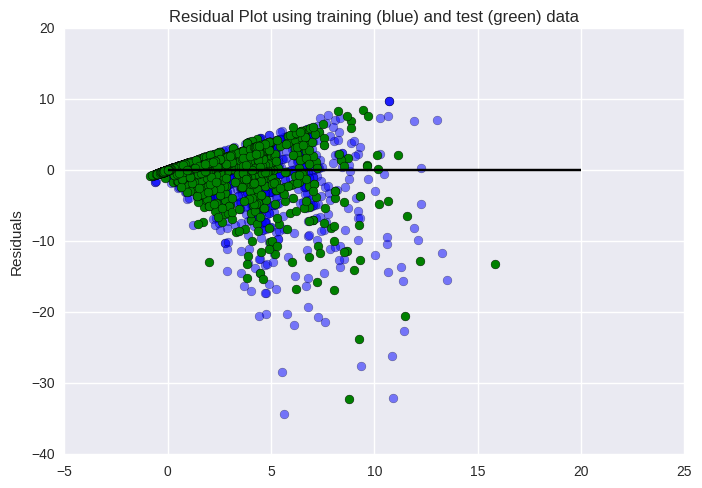

In [30]:


plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 20)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')



In [33]:
import sklearn as sk
lin_model = LinearRegression()
kf = sk.model_selection.KFold(n_splits=4, shuffle=True)
error_array = []
train_error = []
for train_idx, test_idx in kf.split(X):
    lin_model.fit(X.iloc[train_idx], Y_priorTotals[train_idx])
    predicted_col = lin_model.predict(X.iloc[test_idx])
    predict_train = lin_model.predict(X.iloc[train_idx])
    mseTrain = np.mean((predict_train-Y_priorTotals[train_idx])**2)
    mseKFold4 = np.mean((predicted_col - Y_priorTotals[test_idx])**2)
    error_array = np.append(error_array, mseKFold4)
    train_error = np.append(train_error,mseTrain)
print(np.mean(error_array))
print("training error mean: ", np.mean(train_error))

2.34462669952
training error mean:  2.3280118918


In [44]:
from sklearn import linear_model as lm
cycling_linear = LinearRegression()
cycling_lasso = lm.Lasso()
cycling_ridge = lm.Ridge(alpha =10)

In [35]:
pd.DataFrame(list(zip(X.columns, lin_model.coef_)), columns = ['features', 'estimatedCoefficients'])

,features,estimatedCoefficients
0,bike traffic estimate,0.000611
1,vehicle traffic,-0.000007
2,pedestrian traffic,0.000171
3,fatal,1.281418
4,major,2.512042
5,no control,-0.608624
6,other/unrecorded,-1.590119
7,pedestrian crossover,-0.222739
8,stop/yield sign,0.162509
9,traffic signal/gate,2.258972


In [45]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
predicted = cross_val_predict(cycling_linear,X,Y_priorTotals,cv=5)
linear_score = cross_val_score(cycling_linear,X,Y_priorTotals,cv=5)
print("linear score: ", np.mean(linear_score))
print("predicted: ", predicted)

linear score:  0.509726698877
predicted:  [ 2.29679342 -0.17524568 -0.28870012 ...,  1.57476499  0.14444765
  0.14444765]


In [47]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
predicted = cross_val_predict(cycling_ridge,X,Y_priorTotals,cv=5)
linear_score = cross_val_score(cycling_ridge,X,Y_priorTotals,cv=5)
print("linear score: ", np.mean(linear_score))
print("predicted: ", predicted)

linear score:  0.509826411631
predicted:  [ 2.310651   -0.16384382 -0.28807339 ...,  1.58698164  0.14588797
  0.14588797]


In [48]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
predicted = cross_val_predict(cycling_lasso,X,Y_priorTotals,cv=5)
linear_score = cross_val_score(cycling_lasso,X,Y_priorTotals,cv=5)
print("linear score: ", np.mean(linear_score))
print("predicted: ", predicted)

linear score:  0.113435894419
predicted:  [ 1.99255486  1.07332599  0.09912608 ...,  0.72558899  0.72558899
  0.72558899]


In [51]:
len(predicted)
Y=Y_priorTotals

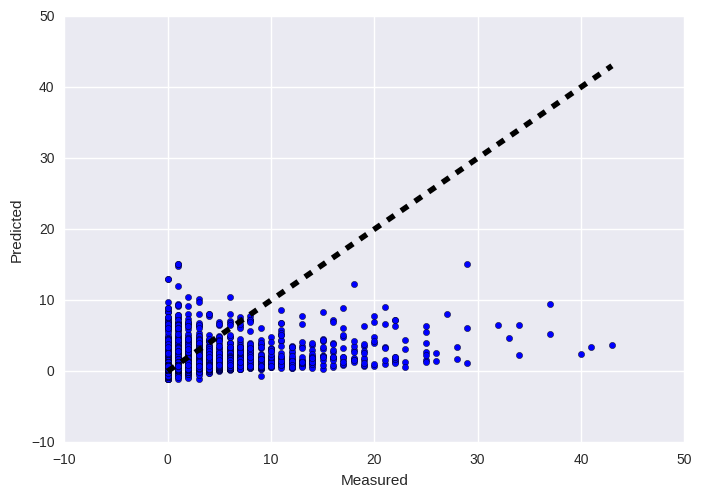

In [53]:
fig, ax = plt.subplots()
ax.scatter(Y, predicted)
ax.plot([Y.min(), Y.max()], [Y.min(), Y.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

### We know what our training test error looks like for this model. What about for a exponential one? 
Lets use the coefficients we found as the starting point in an exponential reression.
#### DOING LATER

In [25]:
X=Xrf.copy()

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn import preprocessing
raw_bike = X['bike traffic estimate'].reshape(-1,1)
raw_veh = X['vehicle traffic'].reshape(-1,1)
raw_ped = X['pedestrian traffic'].reshape(-1,1)
bike_scaler = preprocessing.StandardScaler().fit(raw_bike)
veh_scaler = preprocessing.StandardScaler().fit(raw_veh)
ped_scaler = preprocessing.StandardScaler().fit(raw_ped)
X_scaled_bike = bike_scaler.transform(raw_bike)
X_scaled_veh = veh_scaler.transform(raw_veh)
X_scaled_ped = ped_scaler.transform(raw_ped)
X['bike traffic estimate'] = X_scaled_bike
X['vehicle traffic'] = X_scaled_veh
X['ped_scaler'] = X_scaled_ped

In [56]:
raw_bike = Xc['bike traffic estimate'].reshape(-1,1)
raw_veh = Xc['vehicle traffic'].reshape(-1,1)
raw_ped = Xc['pedestrian traffic'].reshape(-1,1)
bike_scaler_c = preprocessing.StandardScaler().fit(raw_bike)
veh_scaler_c = preprocessing.StandardScaler().fit(raw_veh)
ped_scaler_c = preprocessing.StandardScaler().fit(raw_ped)
Xc_scaled_bike = bike_scaler_c.transform(raw_bike)
Xc_scaled_veh = veh_scaler_c.transform(raw_veh)
Xc_scaled_ped = ped_scaler_c.transform(raw_ped)
Xc['bike traffic estimate'] = Xc_scaled_bike
Xc['vehicle traffic'] = Xc_scaled_veh
Xc['ped_scaler'] = Xc_scaled_ped

In [57]:
X= df_data.drop(['normalized yearly accident rate','posterior mean rate','posterior STD','total collisions','normalized_risk_factor','road_class','control type','minor','minimal/none','scaled collisions'],axis=1)
Y_priorTotals = df_data['total collisions']
Y_priorRate = df_data['normalized yearly accident rate']
Y_postRate = df_data['posterior mean rate']
Y_priorRiskRate = df_data['normalized_risk_factor']

Xc= df_data_central.drop(['normalized yearly accident rate','posterior mean rate','posterior STD','total collisions','normalized_risk_factor','road_class','control type','minor','minimal/none','scaled collisions'],axis=1)
Yc_priorTotals = df_data_central['total collisions']
Yc_priorRate = df_data_central['normalized yearly accident rate']
Yc_postRate = df_data_central['posterior mean rate']
Yc_priorRiskRate = df_data_central['normalized_risk_factor']

In [58]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_priorTotals, test_size=0.33, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

lm = LinearRegression()
lm.fit(X_train, Y_train)
pred_train = lm.predict(X_train)
pred_test = lm.predict(X_test)

mseTrain = np.mean((Y_train - lm.predict(X_train))**2)
mseTest = np.mean((Y_test - lm.predict(X_test))**2)
print("Calculated mean squared error using the training data: ",mseTrain)
print("Calculated mean squared error using the test data: ",mseTest)


(13648, 14)
(6723, 14)
(13648,)
(6723,)
Calculated mean squared error using the training data:  2.407771656160796
Calculated mean squared error using the test data:  2.179085381400197


In [59]:
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc_priorTotals, test_size=0.33, random_state = 5)
print (Xc_train.shape)
print (Xc_test.shape)
print (Yc_train.shape)
print (Yc_test.shape)

# your turn
lmc = LinearRegression()
lmc.fit(Xc_train, Yc_train)
pred_c_train = lmc.predict(Xc_train)
pred_c_test = lmc.predict(Xc_test)

mseTrain = np.mean((Yc_train - lmc.predict(Xc_train))**2)
mseTest = np.mean((Yc_test - lmc.predict(Xc_test))**2)
print("Calculated mean squared error using the training data: ",mseTrain)
print("Calculated mean squared error using the test data: ",mseTest)


(12524, 14)
(6169, 14)
(12524,)
(6169,)
Calculated mean squared error using the training data:  1.2939816560433808
Calculated mean squared error using the test data:  1.033102796944113


In [60]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
predicted = cross_val_predict(lm,X,Y_priorTotals,cv=10)
linear_score = cross_val_score(lm,X,Y_priorTotals,cv=10)
print("linear score: ", np.mean(linear_score))
print("predicted: ", predicted)

linear score:  0.502187655283
predicted:  [ 2.29571038 -0.14017886 -0.27011458 ...,  1.5901919   0.16036739
  0.16036739]


In [62]:
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import cross_val_score
predicted_c = cross_val_predict(lmc,Xc,Yc_priorTotals,cv=10)
linear_score = cross_val_score(lmc,Xc,Yc_priorTotals,cv=10)
print("linear score: ", np.mean(linear_score))
print("predicted_c: ", predicted_c)

linear score:  0.57097745701
predicted_c:  [ 2.03992269 -0.23884586 -0.11524913 ...,  0.03440393  0.03440393
  0.03440393]


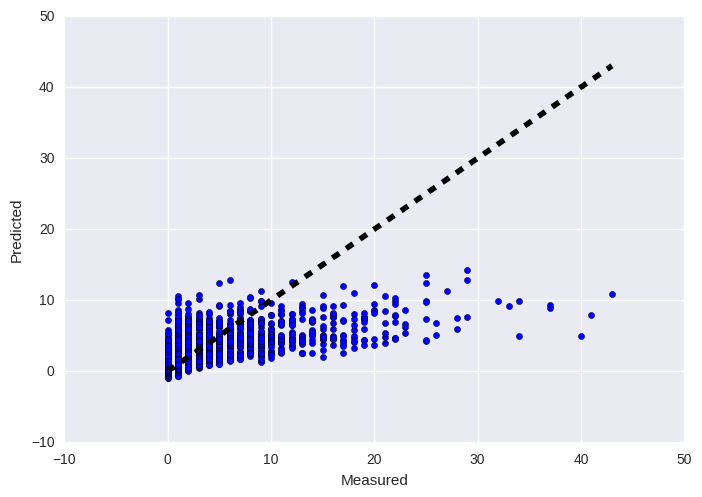

In [63]:
fig, ax = plt.subplots()
ax.scatter(Y_priorTotals, predicted)
ax.plot([Y.min(), Y_priorTotals.max()], [Y_priorTotals.min(), Y_priorTotals.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

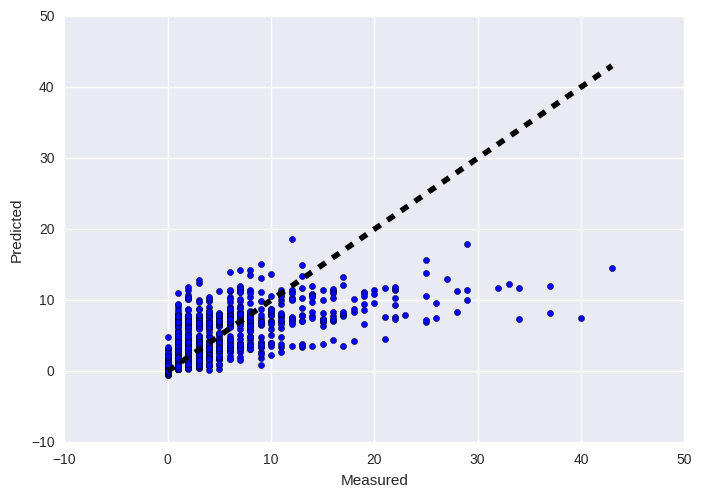

In [64]:
fig, ax = plt.subplots()
ax.scatter(Yc_priorTotals, predicted_c)
ax.plot([Yc_priorTotals.min(), Yc_priorTotals.max()], [Yc_priorTotals.min(), Yc_priorTotals.max()], 'k--', lw=4)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()

In [65]:
from sklearn import linear_model
lasso_fit = linear_model.LassoCV()
lasso_predicted = cross_val_predict(lasso_fit,X,Y_priorTotals)
lasso_score = cross_val_score(lasso_fit,X,Y_priorTotals)
np.mean(lasso_score)

0.11720553444587538

In [66]:
from sklearn import linear_model
lasso_fit = linear_model.LassoCV(n_alphas = 500)
lasso_predicted = cross_val_predict(lasso_fit,Xc,Yc_priorRate)
lasso_score = cross_val_score(lasso_fit,Xc,Yc_priorRate)
np.mean(lasso_score)

0.13913816130092363

In [67]:
from sklearn import linear_model
ridge_fit = linear_model.RidgeCV([0.001,0.01,0.1,1.0,10])
ridge_predicted = cross_val_predict(ridge_fit,X,Y_priorTotals)
ridge_score = cross_val_score(ridge_fit,X,Y_priorTotals)
np.mean(ridge_score)

0.50831838138483254

In [68]:
from sklearn import linear_model
ridge_fit = linear_model.RidgeCV([0.001,0.01,0.1,1.0,10])
ridge_predicted = cross_val_predict(ridge_fit,Xc,Yc_priorTotals)
ridge_score = cross_val_score(ridge_fit,Xc,Yc_priorTotals)
np.mean(ridge_score)

0.60969485464941364

### Big jump in score here. Even with pedestrian and vehicle numbers thrown in. However, obviously these are denser in the central neighborhoods. So more accurate to map them to the closest data point. 

In [83]:
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc, Yc_priorTotals, test_size=0.25, random_state = 5)
print (Xc_train.shape)
print (Xc_test.shape)
print (Yc_train.shape)
print (Yc_test.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y_priorTotals, test_size=0.25, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(14019, 14)
(4674, 14)
(14019,)
(4674,)
(15278, 14)
(5093, 14)
(15278,)
(5093,)


In [88]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf= RandomForestRegressor(n_estimators = 200)
rf.fit(X_train,Y_train)
r2 = r2_score(Y_test, rf.predict(X_test))
mse = np.mean((Y_test-rf.predict(X_test))**2)
print('MSE : ',mse)

print("R^2 : ", r2)

MSE :  1.9724236765966972
R^2 :  0.576157540983


In [90]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_c= RandomForestRegressor(n_estimators = 200)
rf_c.fit(Xc_train,Yc_train)
r2 = r2_score(Yc_test, rf_c.predict(Xc_test))
mse = np.mean((Yc_test-rf_c.predict(Xc_test))**2)
print('MSE : ',mse)

print("R^2 : ", r2)

MSE :  0.8547477827761945
R^2 :  0.696074054958


In [91]:
names = list(X.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.23780000000000001, 'traffic signal/gate'), (0.19439999999999999, 'pedestrian traffic'), (0.17660000000000001, 'other/unrecorded'), (0.16650000000000001, 'bike traffic estimate'), (0.1399, 'vehicle traffic'), (0.043400000000000001, 'major'), (0.015800000000000002, 'Major Arterial'), (0.0057999999999999996, 'stop/yield sign'), (0.0053, 'Minor Arterial'), (0.0053, 'Collector/Expressway'), (0.0050000000000000001, 'no control'), (0.0032000000000000002, 'Local/Laneway'), (0.00080000000000000004, 'fatal'), (0.00020000000000000001, 'pedestrian crossover')]


## Let's drop our bike traffic estimates and see how performance changes 

In [92]:
X2 = X.drop(['bike traffic estimate'],axis=1)
Xc2 = Xc.drop(['bike traffic estimate'],axis=1)

In [98]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X2, Y_priorTotals, test_size=0.25, random_state = 9)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(15278, 13)
(5093, 13)
(15278,)
(5093,)


In [99]:
from sklearn.model_selection import train_test_split
X2c_train, X2c_test, Yc_train, Yc_test = train_test_split(Xc2, Yc_priorTotals, test_size=0.25, random_state = 9)
print (X2c_train.shape)
print (X2c_test.shape)
print (Yc_train.shape)
print (Yc_test.shape)

(14019, 13)
(4674, 13)
(14019,)
(4674,)


In [100]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf= RandomForestRegressor(n_estimators = 200)
rf.fit(X_train,Y_train)
r2 = r2_score(Y_test, rf.predict(X_test))
mse = np.mean((Y_test-rf.predict(X_test))**2)
print('MSE : ',mse)

print("R^2 : ", r2)

MSE :  2.1142846536768345
R^2 :  0.595916409159


In [102]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_c= RandomForestRegressor(n_estimators = 200)
rf_c.fit(X2c_train,Yc_train)
r2_c = r2_score(Yc_test, rf_c.predict(X2c_test))
mse = np.mean((Yc_test-rf_c.predict(X2c_test))**2)
print('MSE : ',mse)

print("R^2 : ", r2_c)

MSE :  0.9716666541882611
R^2 :  0.668586902183


### Large drop in MSE when only looking at central. However testing performance is worse without the bike estimates when looking at central only. Using the full dataset, this actually improves the fit though. 

In [103]:
names = list(X2.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

Features sorted by their score:
[(0.31719999999999998, 'pedestrian traffic'), (0.23319999999999999, 'traffic signal/gate'), (0.18659999999999999, 'other/unrecorded'), (0.17100000000000001, 'vehicle traffic'), (0.047, 'major'), (0.015900000000000001, 'Major Arterial'), (0.0067000000000000002, 'Minor Arterial'), (0.0064999999999999997, 'no control'), (0.0064000000000000003, 'Collector/Expressway'), (0.0040000000000000001, 'stop/yield sign'), (0.0033, 'Local/Laneway'), (0.0016999999999999999, 'fatal'), (0.00050000000000000001, 'pedestrian crossover')]


In [104]:
names2 = list(Xc2.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf_c.feature_importances_), names2), 
             reverse=True))

Features sorted by their score:
[(0.43459999999999999, 'traffic signal/gate'), (0.215, 'pedestrian traffic'), (0.1411, 'vehicle traffic'), (0.10000000000000001, 'other/unrecorded'), (0.061199999999999997, 'major'), (0.021299999999999999, 'Major Arterial'), (0.0094999999999999998, 'no control'), (0.0054999999999999997, 'stop/yield sign'), (0.0054000000000000003, 'Minor Arterial'), (0.0033999999999999998, 'Collector/Expressway'), (0.0023, 'Local/Laneway'), (0.00040000000000000002, 'fatal'), (0.00029999999999999997, 'pedestrian crossover')]


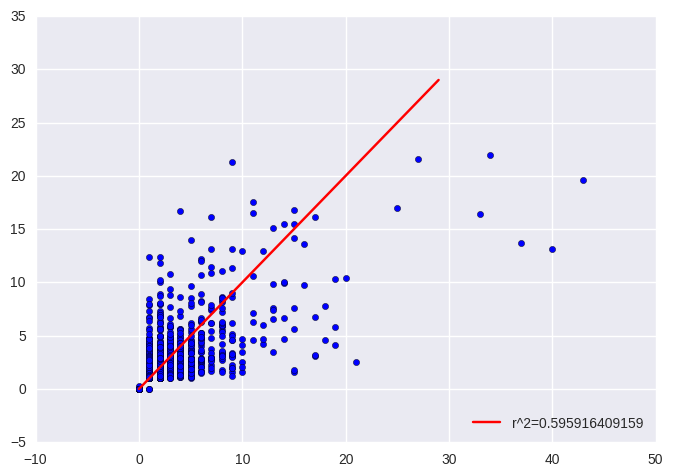

In [105]:
plt.scatter(Y_test,rf.predict(X_test))
plt.plot(np.arange(0,30),np.arange(0,30), label ="r^2="+str(r2), c="r")
plt.legend(loc="lower right")

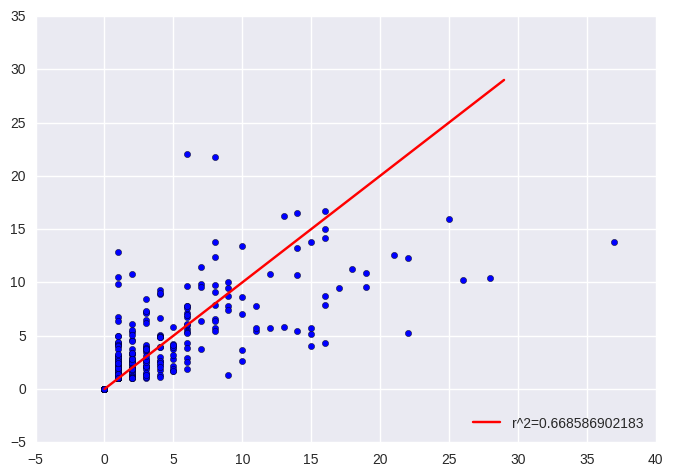

In [106]:
plt.scatter(Yc_test,rf_c.predict(X2c_test))
plt.plot(np.arange(0,30),np.arange(0,30), label ="r^2="+str(r2_c), c="r")
plt.legend(loc="lower right")

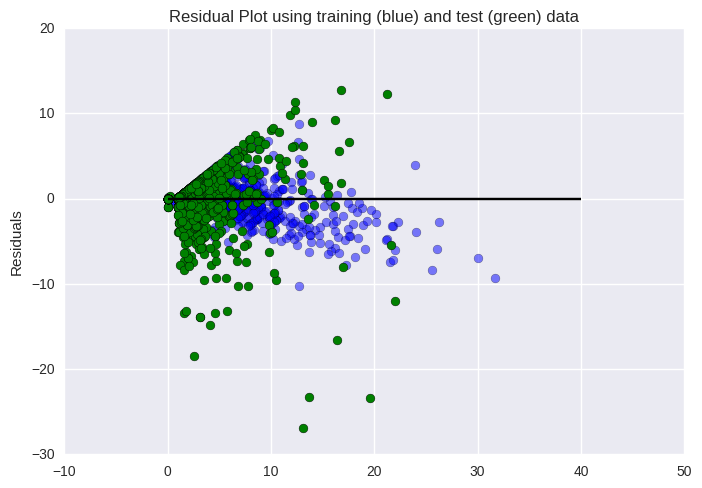

In [107]:

plt.scatter(rf.predict(X_train), rf.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(rf.predict(X_test), rf.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 40)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')


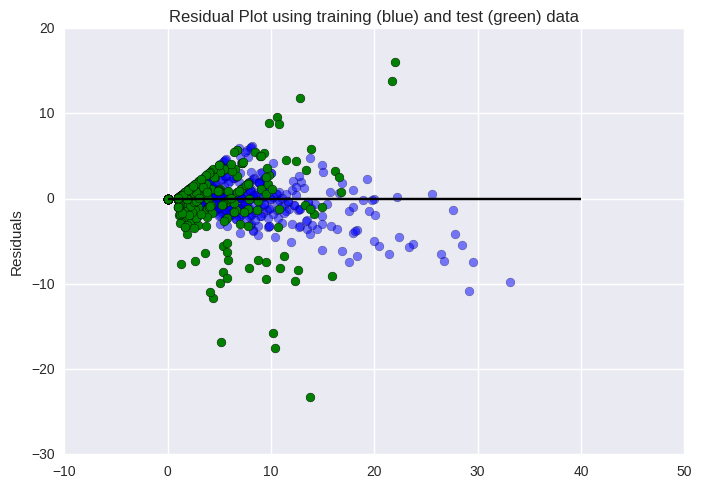

In [108]:

plt.scatter(rf_c.predict(X2c_train), rf_c.predict(X2c_train) - Yc_train, c='b', s=40, alpha=0.5)
plt.scatter(rf_c.predict(X2c_test), rf_c.predict(X2c_test) - Yc_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 40)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

In [109]:
X3 = X2.drop(['fatal','major'],axis=1)
Xc3 = Xc2.drop(['fatal','major'],axis=1)

In [110]:
Y3 = Y_priorTotals/13
Yc3 = Yc_priorTotals/13

In [111]:
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc3, Yc3, test_size=0.25, random_state = 5)
print (Xc_train.shape)
print (Xc_test.shape)
print (Yc_train.shape)
print (Yc_test.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X3, Y3, test_size=0.25, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

(14019, 11)
(4674, 11)
(14019,)
(4674,)
(15278, 11)
(5093, 11)
(15278,)
(5093,)


In [114]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf= RandomForestRegressor(n_estimators = 200)
rf.fit(X_train,Y_train)
r2 = r2_score(Y_test, rf.predict(X_test))
mse = np.mean((Y_test-rf.predict(X_test))**2)
print('MSE : ',mse)

print("R^2 : ", r2)

MSE :  0.01239560241126547
R^2 :  0.549848609548


In [115]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_c= RandomForestRegressor(n_estimators = 200)
rf_c.fit(Xc_train,Yc_train)
r2_c = r2_score(Yc_test, rf_c.predict(Xc_test))
mse = np.mean((Yc_test-rf_c.predict(Xc_test))**2)
print('MSE : ',mse)

print("R^2 : ", r2_c)

MSE :  0.006580987361131232
R^2 :  0.604535454171


In [116]:
names = list(X3.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

names2 = list(Xc3.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf_c.feature_importances_), names2), 
             reverse=True))

Features sorted by their score:
[(0.34920000000000001, 'pedestrian traffic'), (0.23449999999999999, 'traffic signal/gate'), (0.18479999999999999, 'vehicle traffic'), (0.1835, 'other/unrecorded'), (0.0201, 'Major Arterial'), (0.0064999999999999997, 'Collector/Expressway'), (0.0061999999999999998, 'Minor Arterial'), (0.0058999999999999999, 'stop/yield sign'), (0.0051999999999999998, 'no control'), (0.0037000000000000002, 'Local/Laneway'), (0.00040000000000000002, 'pedestrian crossover')]
Features sorted by their score:
[(0.40529999999999999, 'traffic signal/gate'), (0.2213, 'pedestrian traffic'), (0.18640000000000001, 'vehicle traffic'), (0.1174, 'other/unrecorded'), (0.031, 'Major Arterial'), (0.015699999999999999, 'stop/yield sign'), (0.0089999999999999993, 'no control'), (0.0079000000000000008, 'Minor Arterial'), (0.0033, 'Collector/Expressway'), (0.0023, 'Local/Laneway'), (0.00040000000000000002, 'pedestrian crossover')]


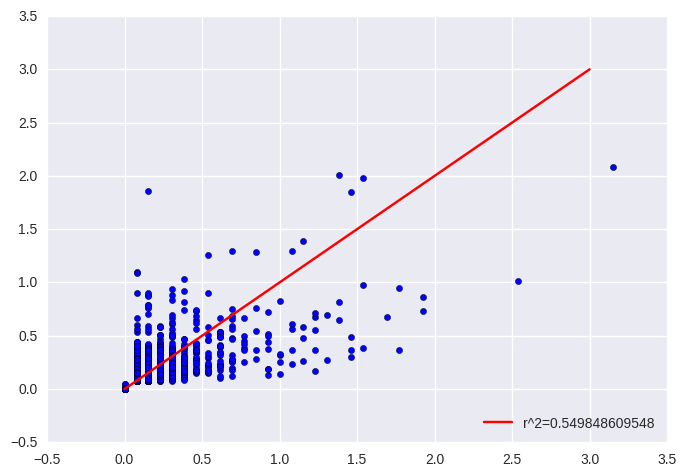

In [117]:
plt.scatter(Y_test,rf.predict(X_test))
plt.plot(np.arange(0,3.5),np.arange(0,3.5), label ="r^2="+str(r2), c="r")
plt.legend(loc="lower right")

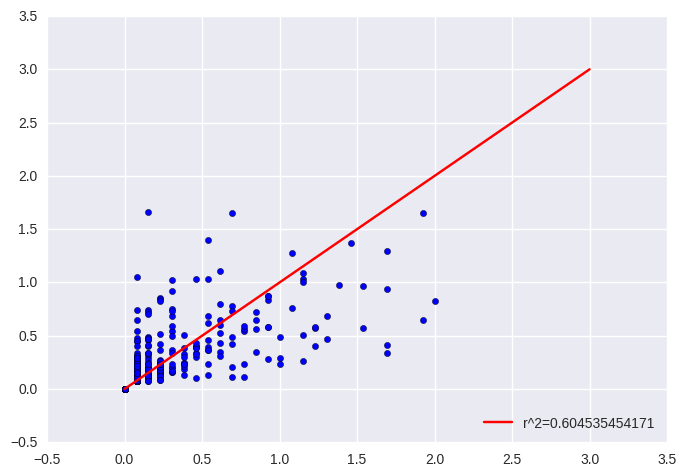

In [118]:
plt.scatter(Yc_test,rf_c.predict(Xc_test))
plt.plot(np.arange(0,4),np.arange(0,4), label ="r^2="+str(r2_c), c="r")
plt.legend(loc="lower right")

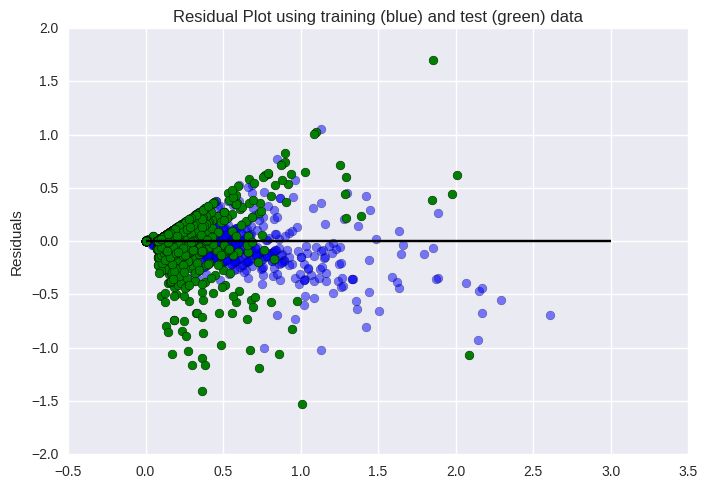

In [119]:
plt.scatter(rf.predict(X_train), rf.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(rf.predict(X_test), rf.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 3)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

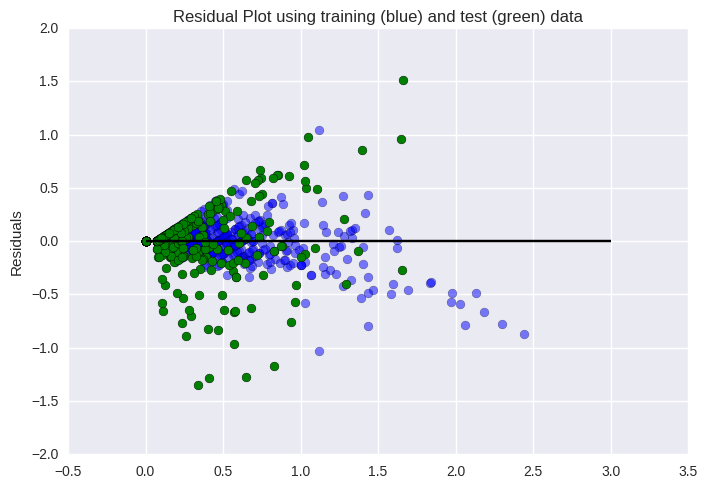

In [120]:
plt.scatter(rf_c.predict(Xc_train), rf_c.predict(Xc_train) - Yc_train, c='b', s=40, alpha=0.5)
plt.scatter(rf_c.predict(Xc_test), rf_c.predict(Xc_test) - Yc_test, c='g', s=40)
plt.hlines(y = 0, xmin=0, xmax = 3)
plt.title('Residual Plot using training (blue) and test (green) data')
plt.ylabel('Residuals')

In [121]:
score = cross_val_score(rf, X3,Y3)
print(np.mean(score))

0.515303851904


In [122]:
score = cross_val_score(rf_c, Xc3,Yc3)
print(np.mean(score))

0.587083916319


### Let's give back the fatal + major features to our data.

In [124]:
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc2, Yc3, test_size=0.25, random_state = 5)
print (Xc_train.shape)
print (Xc_test.shape)
print (Yc_train.shape)
print (Yc_test.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X2, Y3, test_size=0.25, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf= RandomForestRegressor(n_estimators = 20)
rf.fit(X_train,Y_train)
r2 = r2_score(Y_test, rf.predict(X_test))
mse = np.mean((Y_test-rf.predict(X_test))**2)
print('MSE for all data: ', mse)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_c= RandomForestRegressor(n_estimators = 20)
rf_c.fit(Xc_train,Yc_train)
r2_c = r2_score(Yc_test, rf_c.predict(Xc_test))
mse = np.mean((Yc_test-rf_c.predict(Xc_test))**2)
print("MSE for central data: ", mse)

names = list(X2.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

names2 = list(Xc2.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf_c.feature_importances_), names2), 
             reverse=True))

(14019, 13)
(4674, 13)
(14019,)
(4674,)
(15278, 13)
(5093, 13)
(15278,)
(5093,)
MSE for all data:  0.012010067344219956
MSE for central data:  0.006593863047694476
Features sorted by their score:
[(0.33539999999999998, 'pedestrian traffic'), (0.2152, 'traffic signal/gate'), (0.1956, 'other/unrecorded'), (0.16309999999999999, 'vehicle traffic'), (0.046300000000000001, 'major'), (0.019, 'Major Arterial'), (0.0066, 'stop/yield sign'), (0.0053, 'Minor Arterial'), (0.0051000000000000004, 'Collector/Expressway'), (0.0040000000000000001, 'no control'), (0.0033999999999999998, 'Local/Laneway'), (0.00089999999999999998, 'fatal'), (0.00020000000000000001, 'pedestrian crossover')]
Features sorted by their score:
[(0.35070000000000001, 'traffic signal/gate'), (0.2109, 'pedestrian traffic'), (0.1706, 'other/unrecorded'), (0.1636, 'vehicle traffic'), (0.048500000000000001, 'major'), (0.027699999999999999, 'Major Arterial'), (0.0080999999999999996, 'stop/yield sign'), (0.0079000000000000008, 'no cont

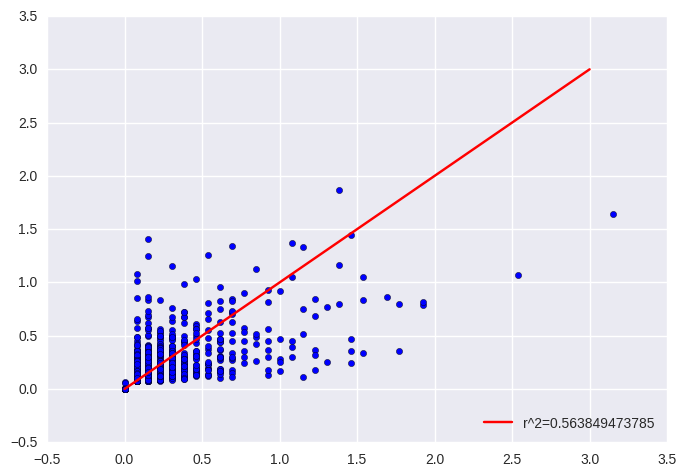

In [125]:
plt.scatter(Y_test,rf.predict(X_test))
plt.plot(np.arange(0,3.5),np.arange(0,3.5), label ="r^2="+str(r2), c="r")
plt.legend(loc="lower right")

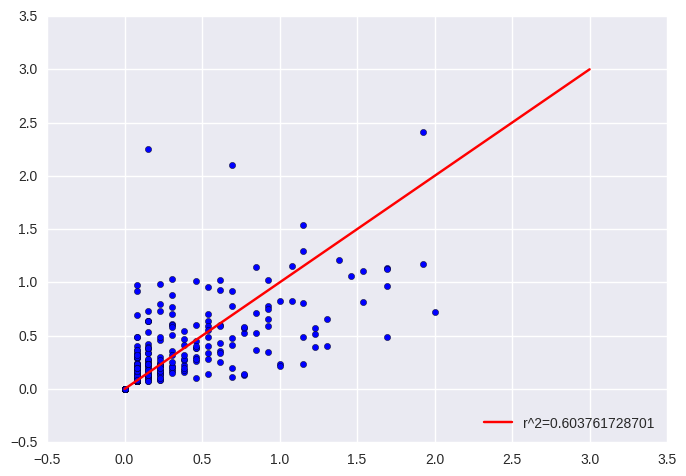

In [126]:
plt.scatter(Yc_test,rf_c.predict(Xc_test))
plt.plot(np.arange(0,4),np.arange(0,4), label ="r^2="+str(r2_c), c="r")
plt.legend(loc="lower right")

In [127]:
score = cross_val_score(rf, X2,Y3)
print(np.mean(score))

0.557140144625


In [128]:
score = cross_val_score(rf_c, Xc2,Yc3)
print(np.mean(score))

0.626859296196


### Defintely an improvement there.

In [129]:
X4 = X2.copy()
Xc4 = Xc2.copy()

In [130]:
X4['Fatal/Major'] = X4['fatal'] +X4['major']
X4.reset_index(inplace=True)
st1 = X4['intersection'].str.split('Ontario, ').str.get(1)

Xc4['Fatal/Major'] = Xc4['fatal'] +Xc4['major']
Xc4.reset_index(inplace=True)
st1_c = Xc4['intersection'].str.split('Ontario, ').str.get(1)

st2 = st1.str.split(' ').str.get(0)
st2.to_csv('postal_codes.csv')
st2_c = st1_c.str.split(' ').str.get(0)
st2_c.to_csv('postal_codes_c.csv')

In [131]:
st2 = pd.DataFrame.from_csv('postal_codes2.csv',header=None)

st2_c = pd.DataFrame.from_csv('postal_codes_c2.csv',header=None)

In [132]:
X4.head()

,intersection,vehicle traffic,pedestrian traffic,fatal,major,no control,other/unrecorded,pedestrian crossover,stop/yield sign,traffic signal/gate,Collector/Expressway,Local/Laneway,Major Arterial,Minor Arterial,Fatal/Major
0,"bpNichol Ln & bpNichol Ln, Toronto, Ontario, M5S",11213.0,4767.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,"Zachary Ct & Zachary Ct, Toronto, Ontario, M6A",12798.0,2011.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,"York Ridge Rd & York Ridge Rd, Toronto, Ontari...",13638.0,72.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,"York Mills Rd & York Ridge Rd, Toronto, Ontari...",13638.0,72.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,"York Mills Rd & York Mills Rd, Toronto, Ontari...",25718.0,1926.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [133]:
X4.set_index('intersection', inplace= True)
Xc4.set_index('intersection', inplace= True)
#X4.drop('index',inplace = True, axis=1)

In [134]:
X4['postal'] = st2[1].values
Xc4['postal'] = st2_c[1].values

In [135]:
X4.drop(['fatal','major'],inplace = True, axis=1)
Xc4.drop(['fatal','major'],inplace= True, axis=1)

In [136]:
postal_df = pd.get_dummies(X4.postal, dummy_na = False)
X4 = pd.concat([X4,postal_df],axis=1)

postal_df = pd.get_dummies(Xc4.postal,dummy_na=False)
Xc4 = pd.concat([Xc4,postal_df],axis=1)

In [137]:
X4.drop('postal',inplace = True, axis = 1)
Xc4.drop('postal',inplace = True, axis = 1)

In [145]:
len(X4)

20371

In [148]:
from sklearn.model_selection import train_test_split
Xc_train, Xc_test, Yc_train, Yc_test = train_test_split(Xc4, Yc3, test_size=0.25, random_state = 5)
print (Xc_train.shape)
print (Xc_test.shape)
print (Yc_train.shape)
print (Yc_test.shape)

X_train, X_test, Y_train, Y_test = train_test_split(X4, Y3, test_size=0.25, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf= RandomForestRegressor(n_estimators = 2000)

rf.fit(X_train,Y_train)
r2 = r2_score(Y_test, rf.predict(X_test))
mse = np.mean((Y_test-rf.predict(X_test))**2)
print('MSE for all data: ', mse)

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf_c= RandomForestRegressor(n_estimators = 2000)
rf_c.fit(Xc_train,Yc_train)
r2_c = r2_score(Yc_test, rf_c.predict(Xc_test))
mse = np.mean((Yc_test-rf_c.predict(Xc_test))**2)
print("MSE for central data: ", mse)

names = list(X4.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))

names2 = list(Xc4.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf_c.feature_importances_), names2), 
             reverse=True))

(14019, 122)
(4674, 122)
(14019,)
(4674,)
(15278, 126)
(5093, 126)
(15278,)
(5093,)
MSE for all data:  0.010154943458961306
MSE for central data:  0.004874353385056369
Features sorted by their score:
[(0.26379999999999998, 'pedestrian traffic'), (0.22969999999999999, 'traffic signal/gate'), (0.18290000000000001, 'other/unrecorded'), (0.096500000000000002, 'vehicle traffic'), (0.042900000000000001, 'Fatal/Major'), (0.0149, 'Major Arterial'), (0.010999999999999999, 'M5T'), (0.0104, 'M6G'), (0.0091999999999999998, 'M6H'), (0.0086, 'M6J'), (0.0076, 'M4W'), (0.0076, 'M4M'), (0.0068999999999999999, 'M5A'), (0.0064000000000000003, 'M5V'), (0.0054999999999999997, 'stop/yield sign'), (0.0048999999999999998, 'no control'), (0.0045999999999999999, 'Minor Arterial'), (0.0044000000000000003, 'M5S'), (0.0044000000000000003, 'M4K'), (0.0044000000000000003, 'Collector/Expressway'), (0.0043, 'M4L'), (0.0041999999999999997, 'M5H'), (0.0041999999999999997, 'M5B'), (0.0040000000000000001, 'M5R'), (0.00300

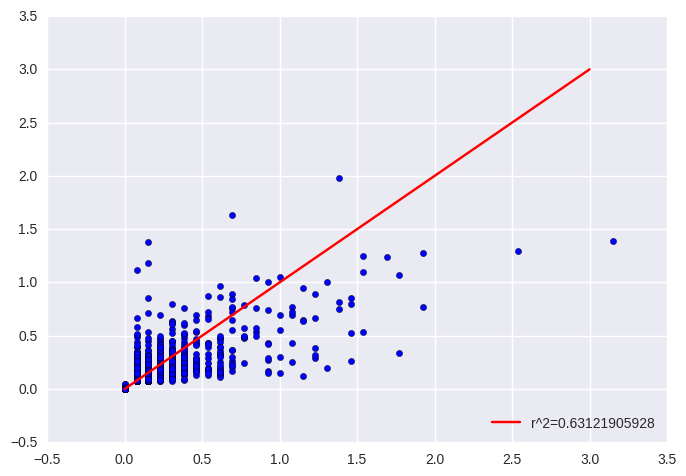

In [149]:
plt.scatter(Y_test,rf.predict(X_test))
plt.plot(np.arange(0,3.5),np.arange(0,3.5), label ="r^2="+str(r2), c="r")
plt.legend(loc="lower right")

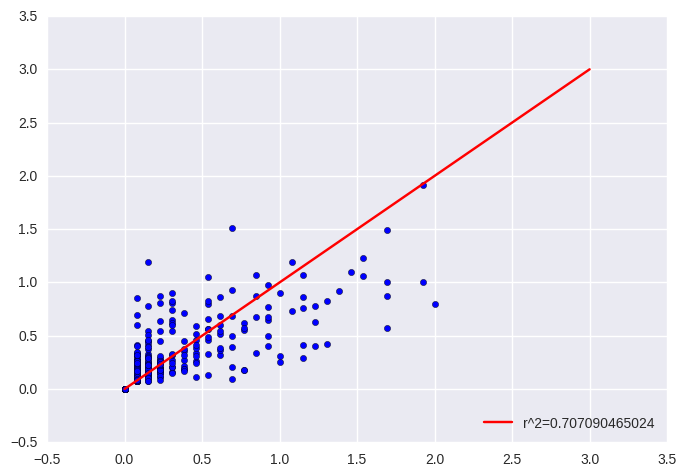

In [150]:
plt.scatter(Yc_test,rf_c.predict(Xc_test))
plt.plot(np.arange(0,3.5),np.arange(0,3.5), label ="r^2="+str(r2_c), c="r")
plt.legend(loc="lower right")

##### So let's go back to our argument that the twitter bot would only give you fatal/major accidents. After all, otherwise why would the police immediateley be called? 

From a PREDICTIVE stand point then, if one wanted to feed in new data to our algorithm, having these two combined as a single feature makes sense. Without the Police's database newly updated, their tweets provide the new data points. We'd retrain with only this info.. Meaning we're likely to be missing out on the minor, and minimals. Which are the bulk of our database.  

In [ ]:
import numpy as np

from time import time
from scipy.stats import randint as sp_randint

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.datasets import load_digits
from sklearn.ensemble import RandomForestClassifier

# build our random forest
clf = RandomForestRegressor(n_estimators=20)


# Utility function to report best scores
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")


# specify parameters and distributions to sample from
param_dist = {"max_depth": [3, None],
              "max_features": sp_randint(30,126),
              "min_samples_split": sp_randint(1, 11),
              "min_samples_leaf": sp_randint(1, 11),
              "bootstrap": [True, False],
              "criterion": ["mse", "mae"]} ##mean squared error, and mean absolute error

# run randomized search
n_iter_search = 20
random_search = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=n_iter_search)

start = time()
random_search.fit(X4, Y3)
print("RandomizedSearchCV took %.2f seconds for %d candidates"
      " parameter settings." % ((time() - start), n_iter_search))
report(random_search.cv_results_)

# use a full grid over all parameters
param_grid = {"max_depth": [3, None],
              "max_features": [15,126],
              "min_samples_split": [1, 3, 10],
              "min_samples_leaf": [1, 3, 10],
              "bootstrap": [True, False],
              "criterion": ["mse", "mae"],
             "n_jobs": -1}

# run grid search
grid_search = GridSearchCV(clf, param_grid=param_grid)
start = time()
grid_search.fit(X4, Yc3)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

In [35]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(X)
X = enc.transform(X)
X_train, X_test, Y_train, Y_test = train_test_split(X, Yrf_priorRate, test_size=0.25, random_state = 5)
print (X_train.shape)
print (X_test.shape)
print (Y_train.shape)
print (Y_test.shape)


from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score
rf= RandomForestRegressor(n_estimators = 20)
rf.fit(X_train,Y_train)
r2 = r2_score(Y_test, rf.predict(X_test))
mse = np.mean((Y_test-rf.predict(X_test))**2)
print('MSE for all data: ', mse)

names = list(X2.columns.values)
print("Features sorted by their score:")
print(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), names), 
             reverse=True))


ValueError: could not convert string to float: 'other/unrecorded'

In [37]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
enc = preprocessing.OneHotEncoder()
enc.fit(X)
#X = enc.transform(X)

ValueError: could not convert string to float: 'other/unrecorded'

In [40]:
X.replace(to_replace='other/unrecorded', value='other', inplace = True)

In [41]:
X.drop('ped_scaler',inplace = True, axis=1)

In [63]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(X['road_class'].tolist())
X['road_class'] = le.transform(X['road_class'].tolist())